# 0.0 Imports

In [ ]:
!pip install inflection
#!pip install boruta
#!pip install xgboost
#!pip install pandas==2.2.2

In [ ]:
import math
import pandas as pd
import inflection
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
from IPython.display import Image
import datetime
from IPython.display import HTML
from scipy import stats as ss
from sklearn.preprocessing import RobustScaler, MinMaxScaler
from sklearn.preprocessing import LabelEncoder
#from boruta import BorutaPy
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression, Lasso
from sklearn.metrics import mean_absolute_error, mean_squared_error#, mean_absolute_percentage_error
import xgboost as xgb
import random

## 0.1 Helper functions

In [ ]:
def cross_validation(x_training, kfold, model_name, model, verbose = False):

    mae_list = []
    mape_list = []
    rmse_list = []
    for k in reversed(range(1,kfold+1)):


        #start and end date for validation
        validation_start_date =  x_training['date'].max() - datetime.timedelta(days = k*6*7)
        validation_end_date =  x_training['date'].max() - datetime.timedelta(days = (k-1)*6*7)
        #filtering dataset
        training = x_training[x_training['date'] < validation_start_date]
        validation = x_training[(x_training['date'] >= validation_start_date) & (x_training['date'] <= validation_end_date)]
        #training and validation dataset
        #training
        xtraining = training.drop(['date', 'sales'], axis = 1)
        ytraining = training['sales']
        #validation
        xvalidation = validation.drop(['date', 'sales'], axis = 1)
        yvalidation = validation['sales']

        #model
        m = model.fit(xtraining, ytraining)
        #prediction
        yhat = m.predict(xvalidation)
        #performance
        m_result = ml_error(model_name, np.expm1(yvalidation), np.expm1(yhat))
        if verbose:
            print('\nK fold number: {}'.format(k))
            print(m_result)

        #store performance of each kfold iteration
        mae_list.append(m_result['MAE'])
        mape_list.append(m_result['MAPE'])
        rmse_list.append(m_result['RMSE'])

    return  pd.DataFrame( {'Model Name': model_name,
                           'MAE CV': [np.round(np.mean(mae_list),2).astype(str)+'+/-'+np.round(np.std(mae_list),2).astype(str)],
                           'MAPE CV': [np.round(np.mean(mape_list),2).astype(str)+'+/-'+np.round(np.std(mape_list),2).astype(str)],
                           'RMSE CV': [np.round(np.mean(rmse_list),2).astype(str)+'+/-'+np.round(np.std(rmse_list),2).astype(str)]}, index=['0'])


def mean_absolute_percentage_error(y, yhat):
    return np.mean(np.abs((y - yhat)/y))

def ml_error(model_name, y, yhat):
    mae = mean_absolute_error(y, yhat)
    mape = mean_absolute_percentage_error(y, yhat)
    rmse = np.sqrt(mean_squared_error(y, yhat))
    return pd.DataFrame({'Model Name': model_name,
                         'MAE': mae,
                         'MAPE': mape,
                         'RMSE': rmse}, index=[0])

def cramer_v(x, y):
    cm = pd.crosstab(x, y).values
    n = cm.sum()
    r, k = cm.shape
    chi2 = ss.chi2_contingency(cm)[0]

    chi2corr = max(0, chi2 - (k-1)* (r-1)/(n-1))

    kcorr = k - (k-1)**2/(n-1)
    rcorr = r - (r-1)**2/(n-1)



    return np.sqrt((chi2corr/n) / min((kcorr-1), (rcorr-1)))

def jupyter_settings():
    %matplotlib inline
    %pylab inline
    plt.style.use( 'bmh' )
    plt.rcParams['figure.figsize'] = [25, 12]
    plt.rcParams['font.size'] = 24
    display( HTML( '<style>.container { width:100% !important; }</style>') )
    pd.options.display.max_columns = None
    pd.options.display.max_rows = None
    pd.set_option( 'display.expand_frame_repr', False )
    sns.set()

In [ ]:
jupyter_settings()

Populating the interactive namespace from numpy and matplotlib


## 0.2 Loading data

In [ ]:
df_sales_raw = pd.read_csv('data/train.csv', low_memory = False, sep=',', on_bad_lines='skip')

In [ ]:
df_sales_raw.shape

(1017209, 9)

In [ ]:
df_store_raw = pd.read_csv('data/store.csv', low_memory = False, sep=',', on_bad_lines='skip' )

In [ ]:
df_store_raw.shape

(1115, 10)

In [ ]:
df_raw = pd.merge(df_sales_raw, df_store_raw, how='left', on='Store')

In [ ]:
df_raw.shape

(1017209, 18)

In [ ]:
df_raw.sample()

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
75216,512,1,2015-05-25,9005,1633,1,0,a,0,b,b,590.0,NaN,NaN,1,5.0,2013.0,"Mar,Jun,Sept,Dec"


# 1.0 Passo 1 - Descrição dos dados

## 1.1 Renomear colunas

In [ ]:
df1 = df_raw.copy()
cols_old = ['Store', 'DayOfWeek', 'Date', 'Sales', 'Customers', 'Open', 'Promo',
       'StateHoliday', 'SchoolHoliday', 'StoreType', 'Assortment',
       'CompetitionDistance', 'CompetitionOpenSinceMonth',
       'CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek',
       'Promo2SinceYear', 'PromoInterval']
# modificando nomes das colunas
snakecase = lambda x: inflection.underscore(x)
cols_new=list(map(snakecase, cols_old))
df1.columns = cols_new

## 1.2 Data dimensions

In [ ]:
print(f'Linhas: {df1.shape[0]}. Colunas: {df1.shape[1]}')

Linhas: 1017209. Colunas: 18


## 1.3 Data types

In [ ]:
df1['date']=pd.to_datetime(df1['date'])
df1.dtypes

,0
store,int64
day_of_week,int64
date,datetime64[ns]
sales,int64
customers,int64
open,int64
promo,int64
state_holiday,object
school_holiday,int64
store_type,object


## 1.4 Check NA

In [ ]:
df1.isna().sum()

,0
store,0
day_of_week,0
date,0
sales,0
customers,0
open,0
promo,0
state_holiday,0
school_holiday,0
store_type,0


## 1.5 Fillout NA

In [ ]:
df1['competition_distance'].max()

75860.0

In [ ]:
#competition_distance
# preenchendo NA com valor grande assumindo que se é NA é porque o copetidor mais próximo está muito longe
df1['competition_distance'] = df1['competition_distance'].apply(lambda x: 200000 if math.isnan(x) else x)
#competition_open_since_month
df1['competition_open_since_month'] =df1.apply(lambda x: x['date'].month if math.isnan(x['competition_open_since_month']) else x['competition_open_since_month'], axis=1)
#competition_open_since_year
df1['competition_open_since_year'] =df1.apply(lambda x: x['date'].year if math.isnan(x['competition_open_since_year']) else x['competition_open_since_year'], axis=1)


In [ ]:
#promo2
#promo2_since_week
df1['promo2_since_week'] =df1.apply(lambda x: x['date'].week if math.isnan(x['promo2_since_week']) else x['promo2_since_week'], axis=1)

#promo2_since_year
df1['promo2_since_year'] =df1.apply(lambda x: x['date'].year if math.isnan(x['promo2_since_year']) else x['promo2_since_year'], axis=1)

#promo_interval
month_map = {1:'Jan' ,2:'Feb' ,3:'Mar' ,4:'Apr' ,5:'May' ,6:'Jun' ,7:'Jul' ,8:'Aug' ,9:'Sep' ,10:'Oct' ,11:'Nov' ,12:'Dec'}

df1['promo_interval'].fillna(0, inplace=True)

df1['month_map'] = df1['date'].dt.month.map(month_map)

df1['is_promo'] = df1[['promo_interval','month_map']].apply(lambda x: 0 if x['promo_interval'] == 0 else 1 if x['month_map'] in x['promo_interval'].split(',') else 0, axis =1)

<ipython-input-18-94dc6e5ce95a>:11: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df1['promo_interval'].fillna(0, inplace=True)


In [ ]:
df1.sample(5).T

,6355,325429,86988,197765,23324
store,781,272,19,411,1025
day_of_week,7,6,4,3,6
date,2015-07-26 00:00:00,2014-09-27 00:00:00,2015-05-14 00:00:00,2015-02-04 00:00:00,2015-07-11 00:00:00
sales,0,3897,0,8504,6236
customers,0,358,0,617,716
open,0,1,0,1,1
promo,0,0,0,1,0
state_holiday,0,0,a,0,0
school_holiday,0,0,0,0,0
store_type,a,a,a,d,a


In [ ]:
df1.isna().sum()

,0
store,0
day_of_week,0
date,0
sales,0
customers,0
open,0
promo,0
state_holiday,0
school_holiday,0
store_type,0


## 1.6 Change types

In [ ]:
df1.dtypes

,0
store,int64
day_of_week,int64
date,datetime64[ns]
sales,int64
customers,int64
open,int64
promo,int64
state_holiday,object
school_holiday,int64
store_type,object


In [ ]:
df1['competition_open_since_month'] = df1['competition_open_since_month'].astype(int)
df1['competition_open_since_year'] = df1['competition_open_since_year'].astype(int)

df1['promo2_since_week'] = df1['promo2_since_week'].astype(int)
df1['promo2_since_year'] = df1['promo2_since_year'].astype(int)

In [ ]:
df1.dtypes

,0
store,int64
day_of_week,int64
date,datetime64[ns]
sales,int64
customers,int64
open,int64
promo,int64
state_holiday,object
school_holiday,int64
store_type,object


## 1.7 Descriptive statistical

In [ ]:
#Separndo colunas de dados numéricos e categóricos
num_attributes = df1.select_dtypes(include=['int32', 'int64', 'float64'])
cat_attributes = df1.select_dtypes(exclude=['int32', 'int64', 'float64', 'datetime64[ns]'])

In [ ]:
cat_attributes.sample()

,state_holiday,store_type,assortment,promo_interval,month_map
58330,0,a,a,"Feb,May,Aug,Nov",Jun


### Numerical Attributes

In [ ]:
# Central tendency: mean, median
ct1 = pd.DataFrame(num_attributes.apply(np.mean)).T
ct2 = pd.DataFrame(num_attributes.apply(np.median)).T
# Dispersion: std, min, max, range, skew, kurtosis
d1 = pd.DataFrame(num_attributes.apply(np.std)).T
d2 = pd.DataFrame(num_attributes.apply(min)).T
d3 = pd.DataFrame(num_attributes.apply(max)).T
d4 = pd.DataFrame(num_attributes.apply(lambda x: x.max()-x.min())).T
d5 = pd.DataFrame(num_attributes.apply(lambda x: x.skew())).T
d6 = pd.DataFrame(num_attributes.apply(lambda x: x.kurtosis())).T

#concatenate
m = pd.concat([d2, d3, d4, ct1, ct2, d1, d5, d6]).T.reset_index()



In [ ]:
m.columns = ['attributes', 'min', 'max', 'range', 'mean', 'median', 'std', 'skew', 'kurtosis']
m

,attributes,min,max,range,mean,median,std,skew,kurtosis
0,store,1.0,1115.0,1114.0,558.429727,558.0,321.908493,-0.000955,-1.200524
1,day_of_week,1.0,7.0,6.0,3.998341,4.0,1.997390,0.001593,-1.246873
2,sales,0.0,41551.0,41551.0,5773.818972,5744.0,3849.924283,0.641460,1.778375
3,customers,0.0,7388.0,7388.0,633.145946,609.0,464.411506,1.598650,7.091773
4,open,0.0,1.0,1.0,0.830107,1.0,0.375539,-1.758045,1.090723
5,promo,0.0,1.0,1.0,0.381515,0.0,0.485758,0.487838,-1.762018
6,school_holiday,0.0,1.0,1.0,0.178647,0.0,0.383056,1.677842,0.815154
7,competition_distance,20.0,200000.0,199980.0,5935.442677,2330.0,12547.646829,10.242344,147.789712
8,competition_open_since_month,1.0,12.0,11.0,6.786849,7.0,3.311085,-0.042076,-1.232607
9,competition_open_since_year,1900.0,2015.0,115.0,2010.324840,2012.0,5.515591,-7.235657,124.071304


<Axes: xlabel='sales', ylabel='Count'>

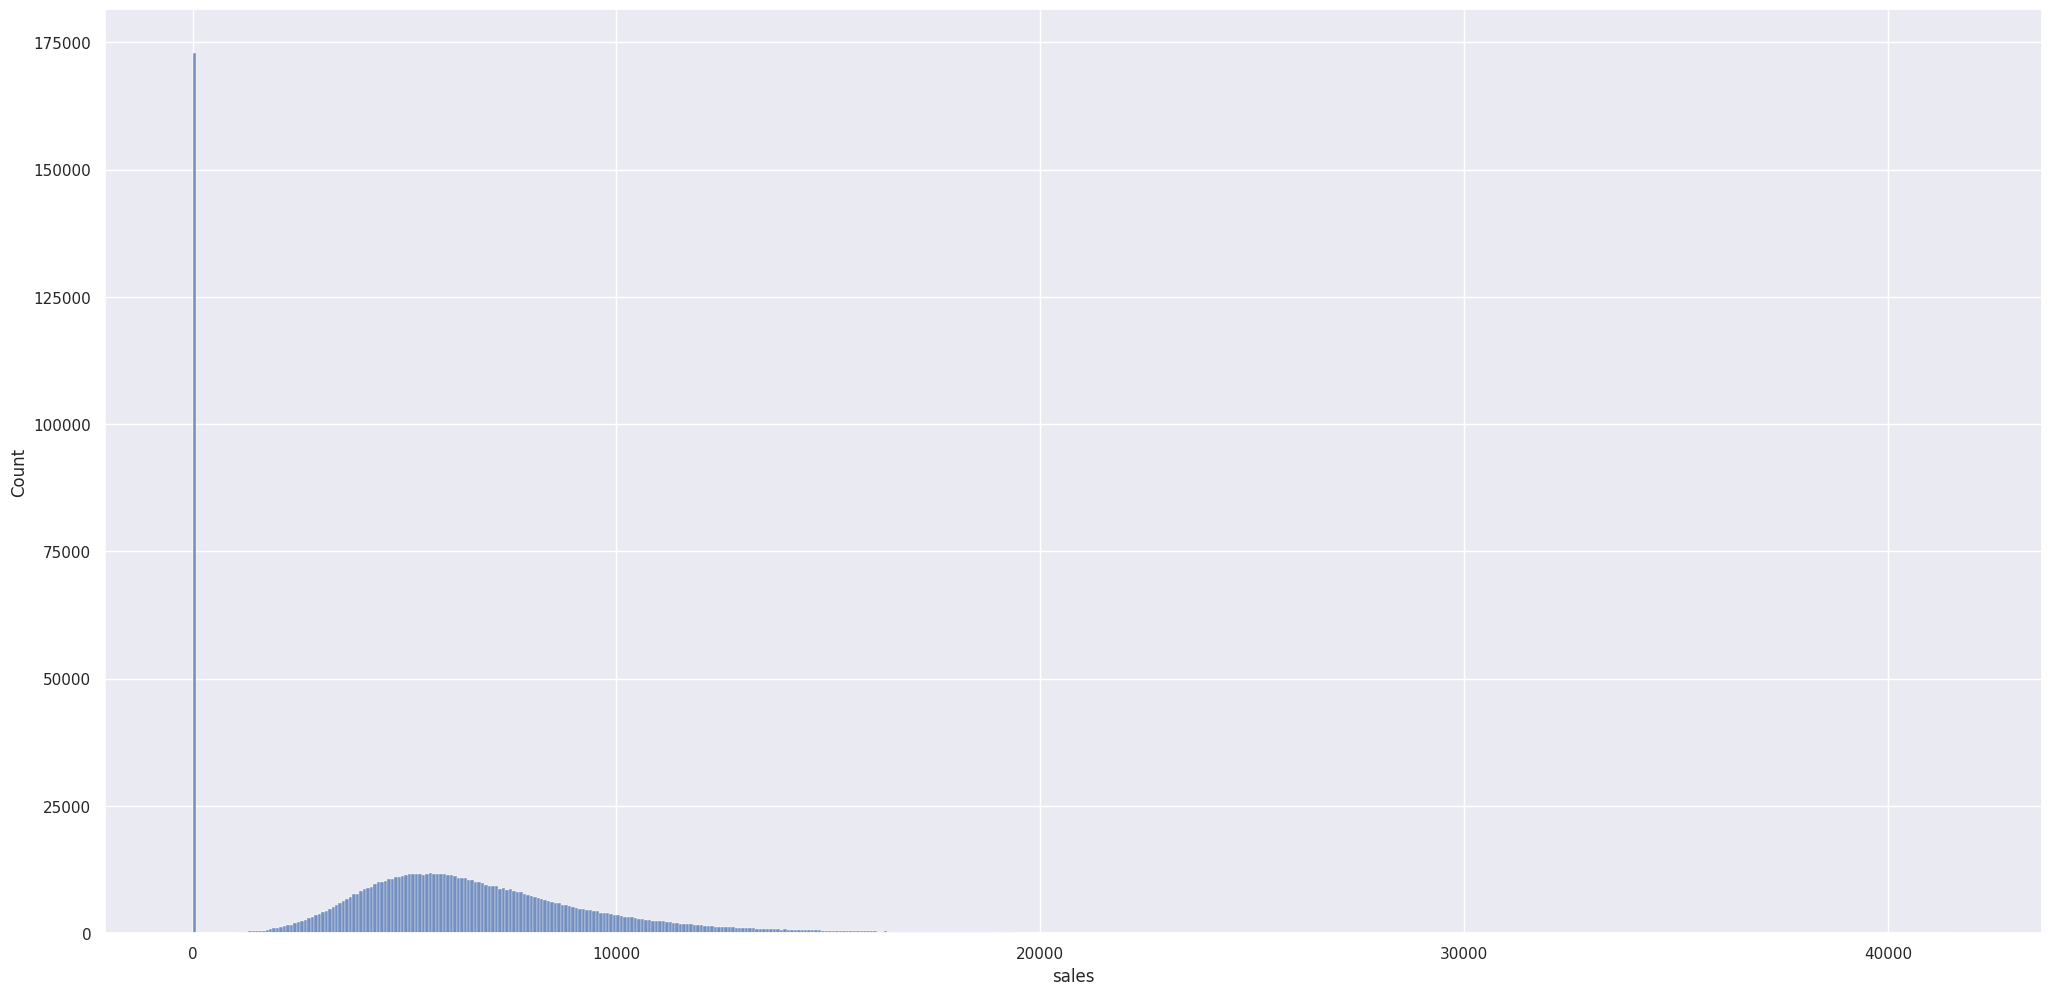

In [ ]:
sns.histplot(df1['sales'])

<Axes: xlabel='competition_distance', ylabel='Density'>

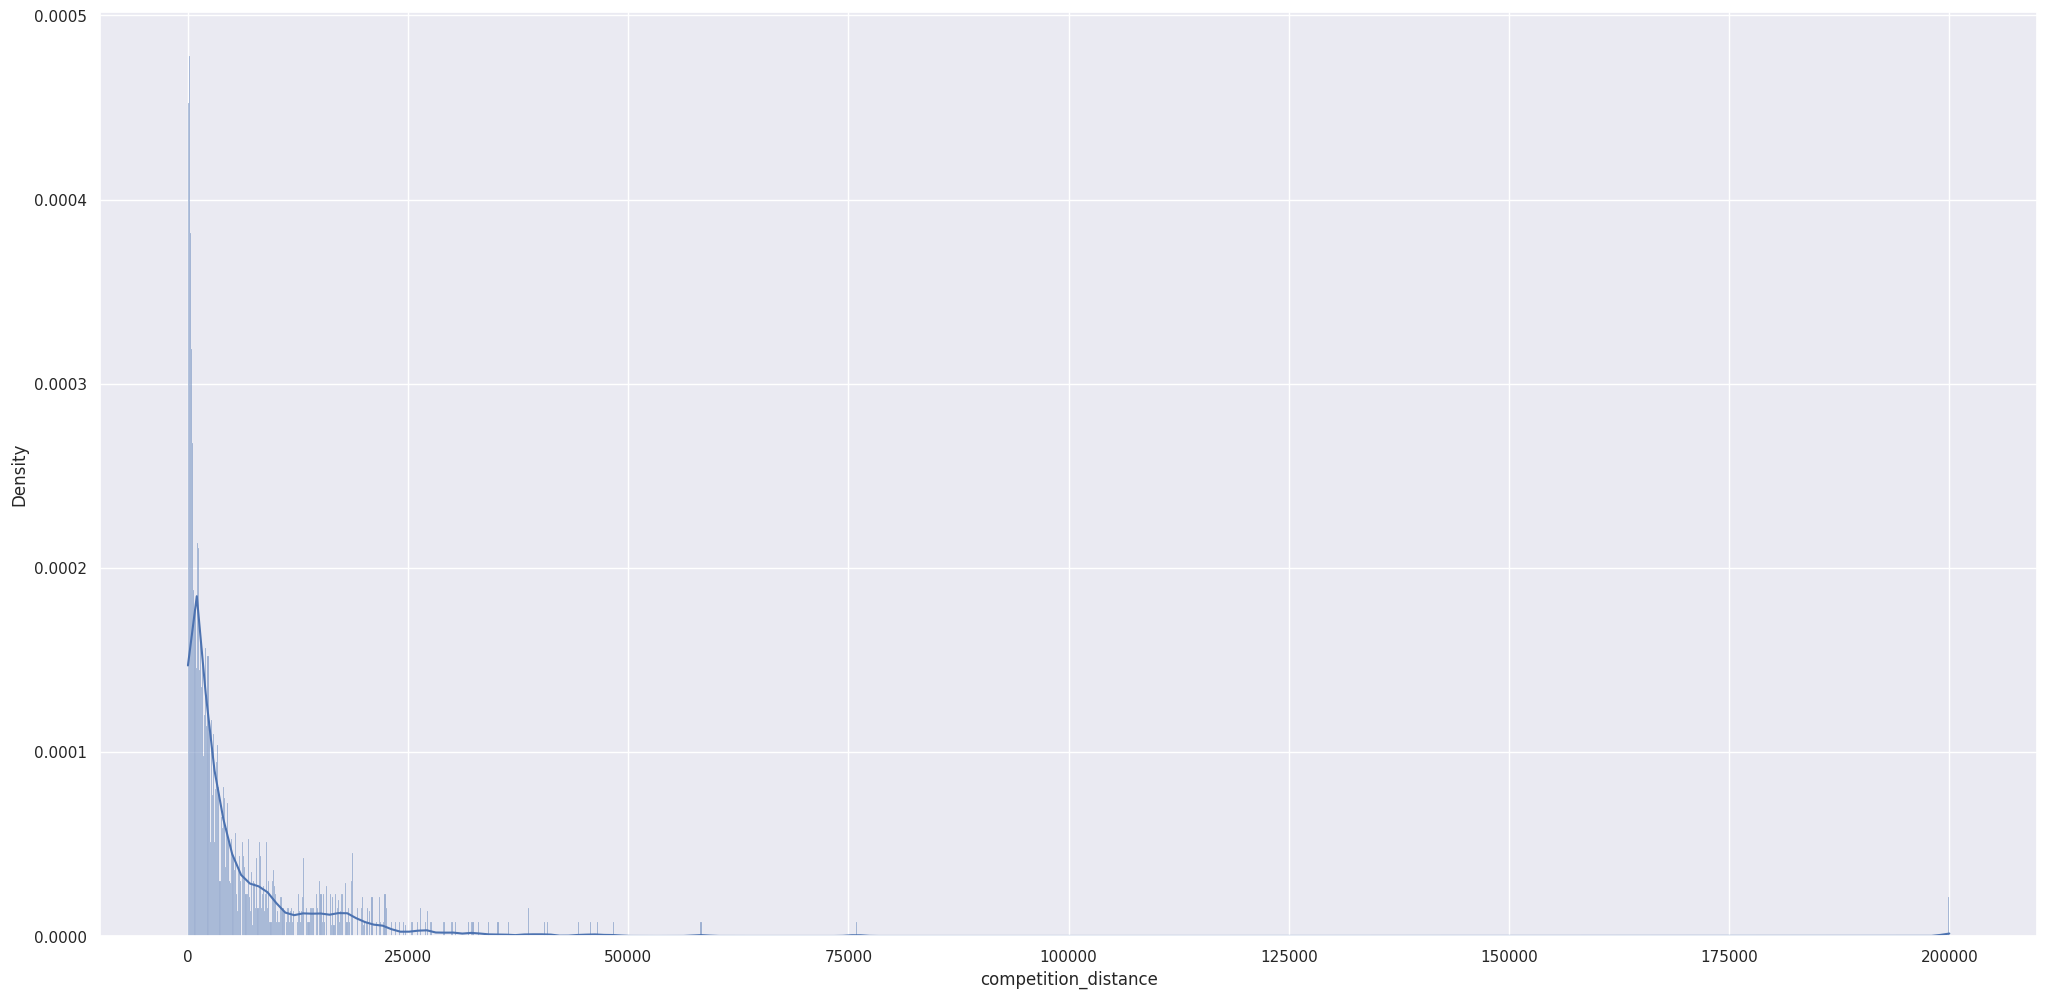

In [ ]:
sns.set_theme()
sns.histplot(df1['competition_distance'], kde=True, stat='density')

### 1.7.2 Categorical attributes

In [ ]:
cat_attributes.apply(lambda x: x.unique().shape[0])

,0
state_holiday,4
store_type,4
assortment,3
promo_interval,4
month_map,12


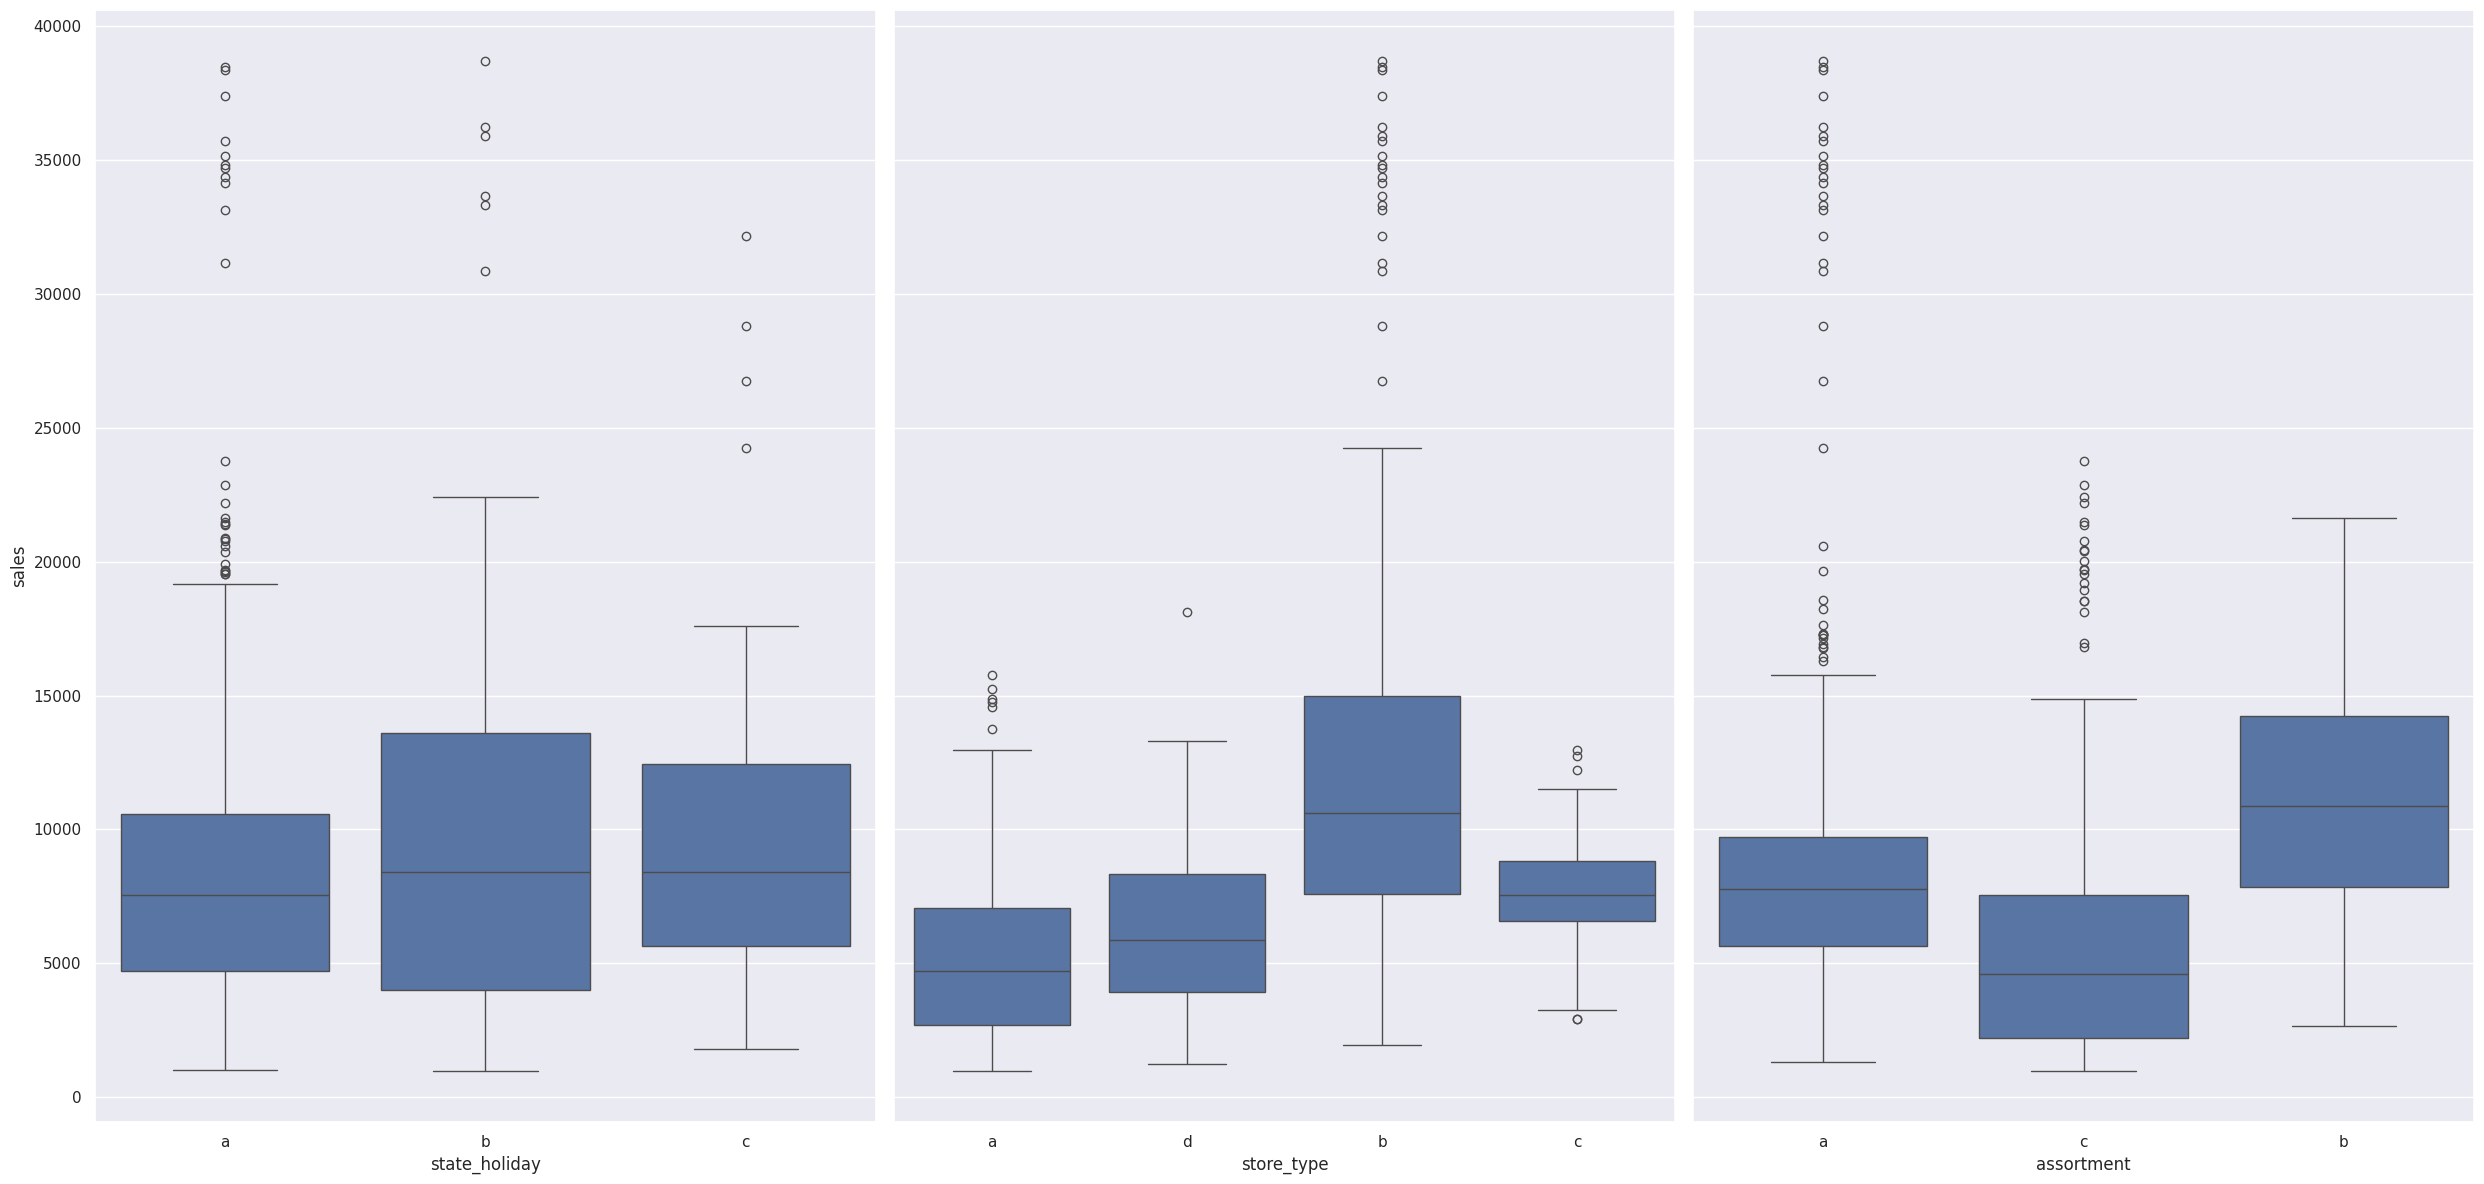

In [ ]:
aux1 = df1[(df1['state_holiday'] != '0') & (df1['sales'] > 0)]
plt.subplot(1,3,1)
sns.boxplot(x='state_holiday', y='sales', data= aux1)

plt.subplot(1,3,2)
sns.boxplot(x='store_type', y='sales', data= aux1)
plt.ylabel('')  # Remove o rótulo 'sales' do eixo Y
plt.gca().set_yticklabels([])  # Remove os valores/ticks do eixo Y

plt.subplot(1,3,3)
sns.boxplot(x='assortment', y='sales', data= aux1)
plt.ylabel('')  # Remove o rótulo 'sales' do eixo Y
plt.gca().set_yticklabels([])  # Remove os valores/ticks do eixo Y

plt.tight_layout()  # Ajusta o espaçamento entre os gráficos


# 2.0 Passo 2 - Feature Engineering

## 2.1 Mapa mental de hipóteses

In [ ]:
Image('img/DAILY_STORE_SALES.png')

FileNotFoundError: No such file or directory: 'img/DAILY_STORE_SALES.png'

FileNotFoundError: No such file or directory: 'img/DAILY_STORE_SALES.png'

<IPython.core.display.Image object>

## 2.1.0 Criação das hipóteses

### 2.1.1 Hipóteses Loja

1. Lojas com maior quadro de funcionários deveriam vender mais
2. Lojas com maior estoque deveriam vender mais
3. Lojas com maior porte deveriam vender mais
4. Lojas com maior sortimento deveriam vender mais

### 2.1.2 Hipóteses Produto

1. Produtos que recebem mais investimento de marketing deveriam vender mais
2. Lojas que expõem mais os produtos em vitrine deveriam vender mais
3. Lojas que possuem preços menores nos produtos deveriam vender mais
4. Lojas que tem preços menores nos produtos por mais tempo deveriam vender mais
   

### 2.1.1 Hipóteses Tempo (Sazonalidade)

1. Lojas com mais feriados deveriam vender menos
2. Lojas que abrem nos últimos 6 meses deveriam vender mais
3. Lojas que abrem nos finais de semana deveriam vender mais

## 2.2 Lista final de hipóteses

Filtrar hipóteses com base no critério de haver ou não dados que possam validar/refutar a hipótese

1. Lojas com maior sortimento deveriam vender mais
2. Lojas com competidores mais próximos deveriam vender menos
3. Lojas com competidores há mais tempo deveriam vender menos

4. Lojas com promoções ativas por mais tempo deveriam vender mais
5. Lojas com mais dias de promoção deveriam vender mais
6. Lojas com mais promoçoes consecutivas deveriam vender mais

7. Lojas com mais feriados deveriam vender menos
8. Lojas que abrem nos últimos 6 meses deveriam vender mais
9. Lojas que abrem nos finais de semana deveriam vender mais

## 2.3 Feature Engineering

In [ ]:
df2 = df1.copy()

In [ ]:
#year
df2['year']=df2['date'].dt.year
#month
df2['month']=df2['date'].dt.month
#day
df2['day']=df2['date'].dt.day
#week of year
df2['week_of_year']=df2['date'].dt.isocalendar().week
#year week
df2['year_week'] = df2['date'].dt.strftime('%Y-%W')


In [ ]:
#competition since
df2['competition_since'] =df2.apply(lambda x: datetime.datetime(year= x['competition_open_since_year'], month=x['competition_open_since_month'] ,day=1 ), axis = 1)
df2['competition_time_month'] =(df2['date'] - df2['competition_since']).apply(lambda x: (x.days)/30).astype(int)
##promo since
df2['promo_since'] =df2['promo2_since_year'].astype(str) +'-'+ df2['promo2_since_week'].astype(str)
df2['promo_since'] =df2['promo_since'].apply(lambda x: datetime.datetime.strptime(x +'-1', '%Y-%W-%w') - datetime.timedelta(days=7))
df2['promo_time_week'] =((df2['date'] - df2['promo_since'])/7).apply(lambda x: x.days).astype(int)
#assortment
df2['assortment'] = df2['assortment'].apply(lambda x: 'basic' if x == 'a' else 'extra' if x == 'b' else 'extended')
#state holiday
df2['state_holiday'] =df2['state_holiday'].apply(lambda x : 'public_holiday' if x == 'a' else 'easter_holiday' if x== 'b' else 'christmas' if x== 'c' else 'regular_day')

In [ ]:

df_t= ((df2.loc[0:5, 'date'] - df2.loc[0:5, 'competition_since']).apply(lambda x: (x.days)/30)).astype(int)
df_t
#df2.loc[0:5 , 'date']

,0
0,84
1,94
2,105
3,71
4,4
5,20


In [ ]:
df2.head().T

,0,1,2,3,4
store,1,2,3,4,5
day_of_week,5,5,5,5,5
date,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00
sales,5263,6064,8314,13995,4822
customers,555,625,821,1498,559
open,1,1,1,1,1
promo,1,1,1,1,1
state_holiday,regular_day,regular_day,regular_day,regular_day,regular_day
school_holiday,1,1,1,1,1
store_type,c,a,a,c,a


In [ ]:
df2.dtypes

,0
store,int64
day_of_week,int64
date,datetime64[ns]
sales,int64
customers,int64
open,int64
promo,int64
state_holiday,object
school_holiday,int64
store_type,object


# 3.0 Passo 3 - Filtragem de variáveis

In [ ]:
df3 = df2.copy()

In [ ]:
df3.head().T

,0,1,2,3,4
store,1,2,3,4,5
day_of_week,5,5,5,5,5
date,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00
sales,5263,6064,8314,13995,4822
customers,555,625,821,1498,559
open,1,1,1,1,1
promo,1,1,1,1,1
state_holiday,regular_day,regular_day,regular_day,regular_day,regular_day
school_holiday,1,1,1,1,1
store_type,c,a,a,c,a


## 3.1 Seleção das linhas
Remover as linhas onde as lojas não estavam abertas e que não tiveram vendas. Pois só intressam linhas com vendas.

In [ ]:
df3 = df3[(df3['open'] != 0) & (df3['sales'] > 0)]

In [ ]:
df3['sales'].min()

46

## 3.2 Seleção das colunas
Remover colunas que não vão poder contribuir com a previsão no momento da previsão.
Embora a coluna customers contenha dados, quando for o momento de realmente fazer a previsão, não há como saber quantos clientes fariam compras nas lojas no futuro. Pra isso, teria que se fazer outro projeto de previsão de clientes e então usar esse valor como input na coluna customers.
Exclui a coluna open pois uma vez que tenha excluido linhas com open != 0, já não tem informação relevante.
Excluir colunas que foram usadas como auxiliares ou das quais se derivou outra coluna.

In [ ]:
cols_drop= ['customers', 'open', 'promo_interval', 'month_map']
df3 = df3.drop(cols_drop, axis = 1)

In [ ]:
df3.columns

Index(['store', 'day_of_week', 'date', 'sales', 'promo', 'state_holiday',
       'school_holiday', 'store_type', 'assortment', 'competition_distance',
       'competition_open_since_month', 'competition_open_since_year', 'promo2',
       'promo2_since_week', 'promo2_since_year', 'is_promo', 'year', 'month',
       'day', 'week_of_year', 'year_week', 'competition_since',
       'competition_time_month', 'promo_since', 'promo_time_week'],
      dtype='object')

# 4.0 Passo 04 - Análise Exploratória de Dados

In [ ]:
df4 = df3.copy()

In [ ]:
#Separndo colunas de dados numéricos e categóricos
num_attributes = df4.select_dtypes(include=['int32', 'int64', 'float64'])
cat_attributes = df4.select_dtypes(exclude=['int32', 'int64', 'float64', 'datetime64[ns]'])

## 4.1 Análise univariada

### 4.1.1 Response variable

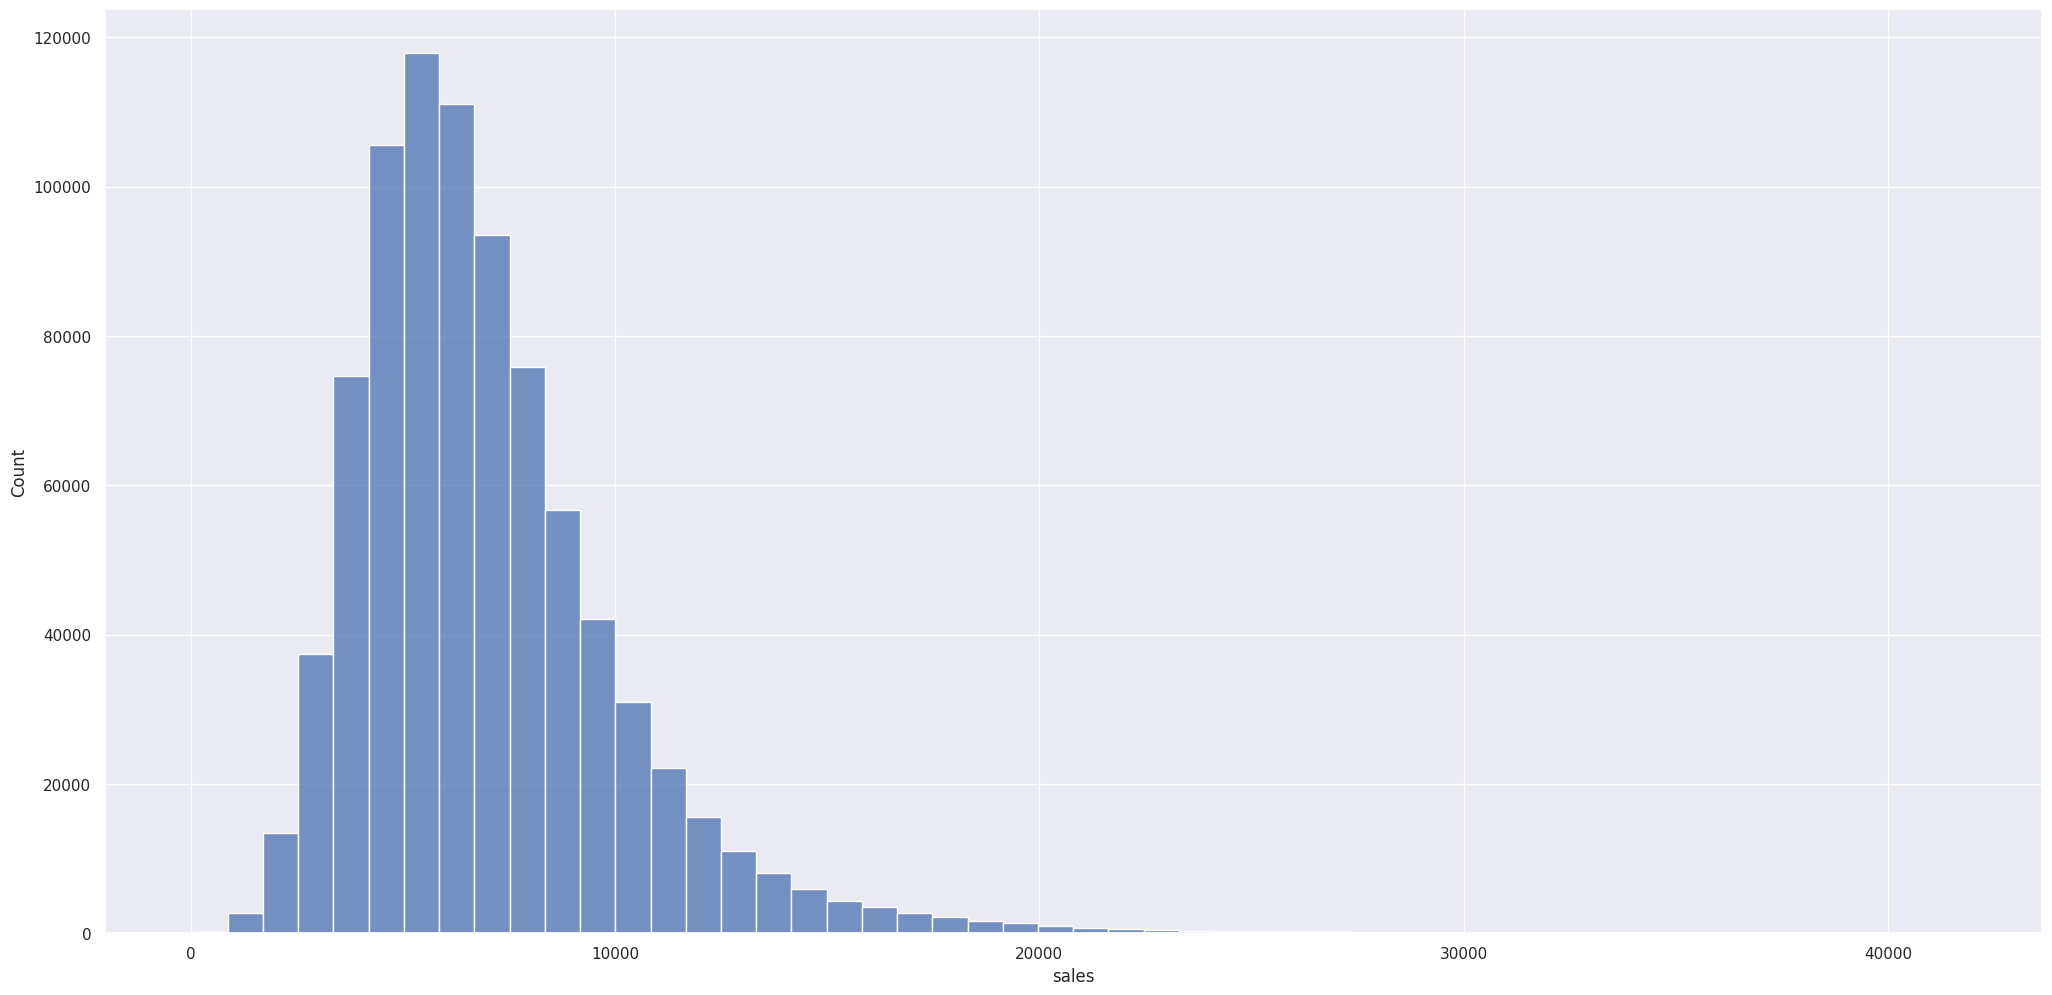

In [ ]:
sns.histplot(df4['sales'], bins = 50);

### 4.1.2 Numerical variable

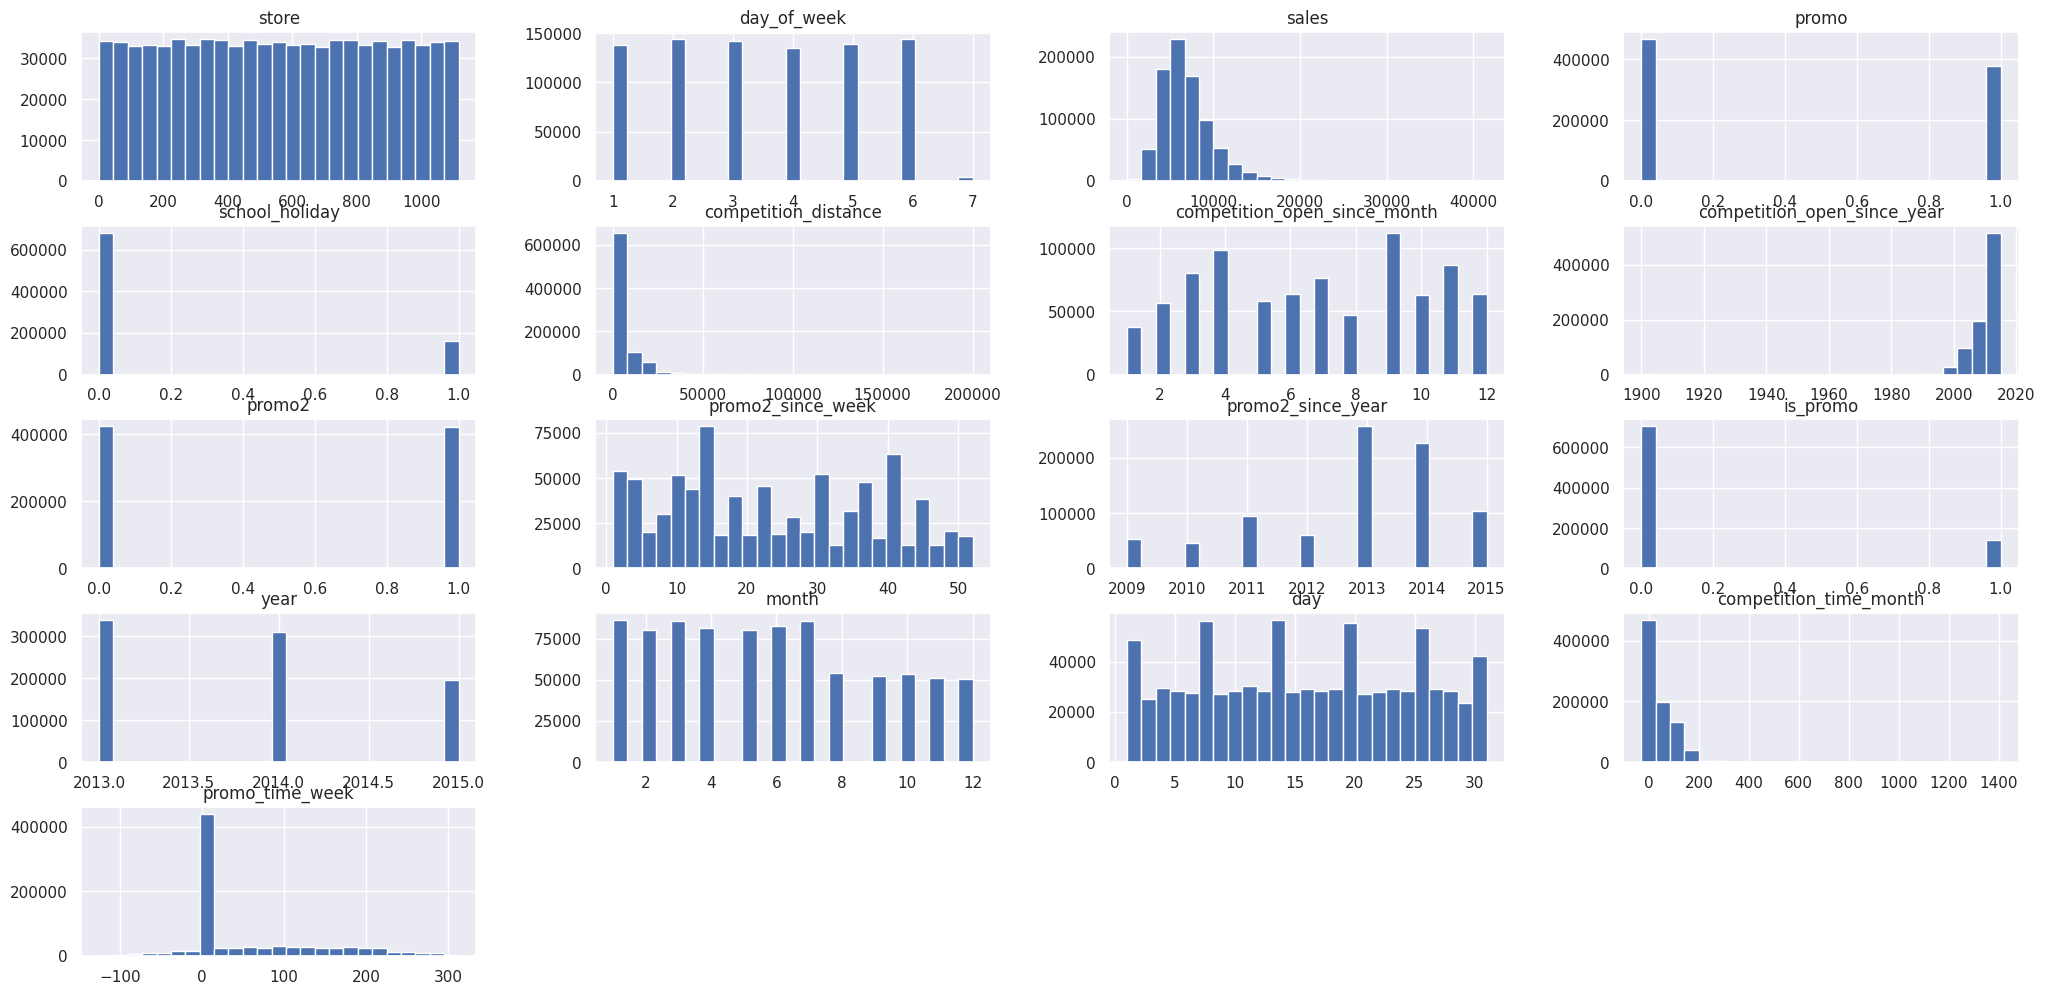

In [ ]:
num_attributes.hist(bins = 25);

In [ ]:
num_attributes.describe().T

,count,mean,std,min,25%,50%,75%,max
store,844338.0,558.421374,321.730861,1.0,280.0,558.0,837.0,1115.0
day_of_week,844338.0,3.520350,1.723712,1.0,2.0,3.0,5.0,7.0
sales,844338.0,6955.959134,3103.815515,46.0,4859.0,6369.0,8360.0,41551.0
promo,844338.0,0.446356,0.497114,0.0,0.0,0.0,1.0,1.0
school_holiday,844338.0,0.193578,0.395102,0.0,0.0,0.0,0.0,1.0
competition_distance,844338.0,5961.827515,12592.181107,20.0,710.0,2330.0,6910.0,200000.0
competition_open_since_month,844338.0,6.787355,3.309917,1.0,4.0,7.0,10.0,12.0
competition_open_since_year,844338.0,2010.331102,5.502628,1900.0,2008.0,2012.0,2014.0,2015.0
promo2,844338.0,0.498670,0.499999,0.0,0.0,0.0,1.0,1.0
promo2_since_week,844338.0,23.629083,14.288315,1.0,12.0,22.0,37.0,52.0


### 4.1.3 Categorical variable

In [ ]:
df4['state_holiday'].drop_duplicates()

,state_holiday
0,regular_day
63559,public_holiday
129424,easter_holiday
241126,christmas


In [ ]:
df4['store_type'].drop_duplicates()

,store_type
0,c
1,a
12,d
84,b


<ipython-input-52-9ee393fd7814>:5: UserWarning: The palette list has more values (8) than needed (3), which may not be intended.
  sns.countplot(data = a, x= 'state_holiday', hue='state_holiday', palette = palette
<ipython-input-52-9ee393fd7814>:17: UserWarning: The palette list has more values (8) than needed (4), which may not be intended.
  sns.countplot(data = df4, x= 'store_type', hue = 'store_type', palette = palette
<ipython-input-52-9ee393fd7814>:30: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data = df4, x= 'assortment', palette = palette
<ipython-input-52-9ee393fd7814>:30: UserWarning: The palette list has more values (8) than needed (3), which may not be intended.
  sns.countplot(data = df4, x= 'assortment', palette = palette


<Axes: xlabel='sales', ylabel='Density'>

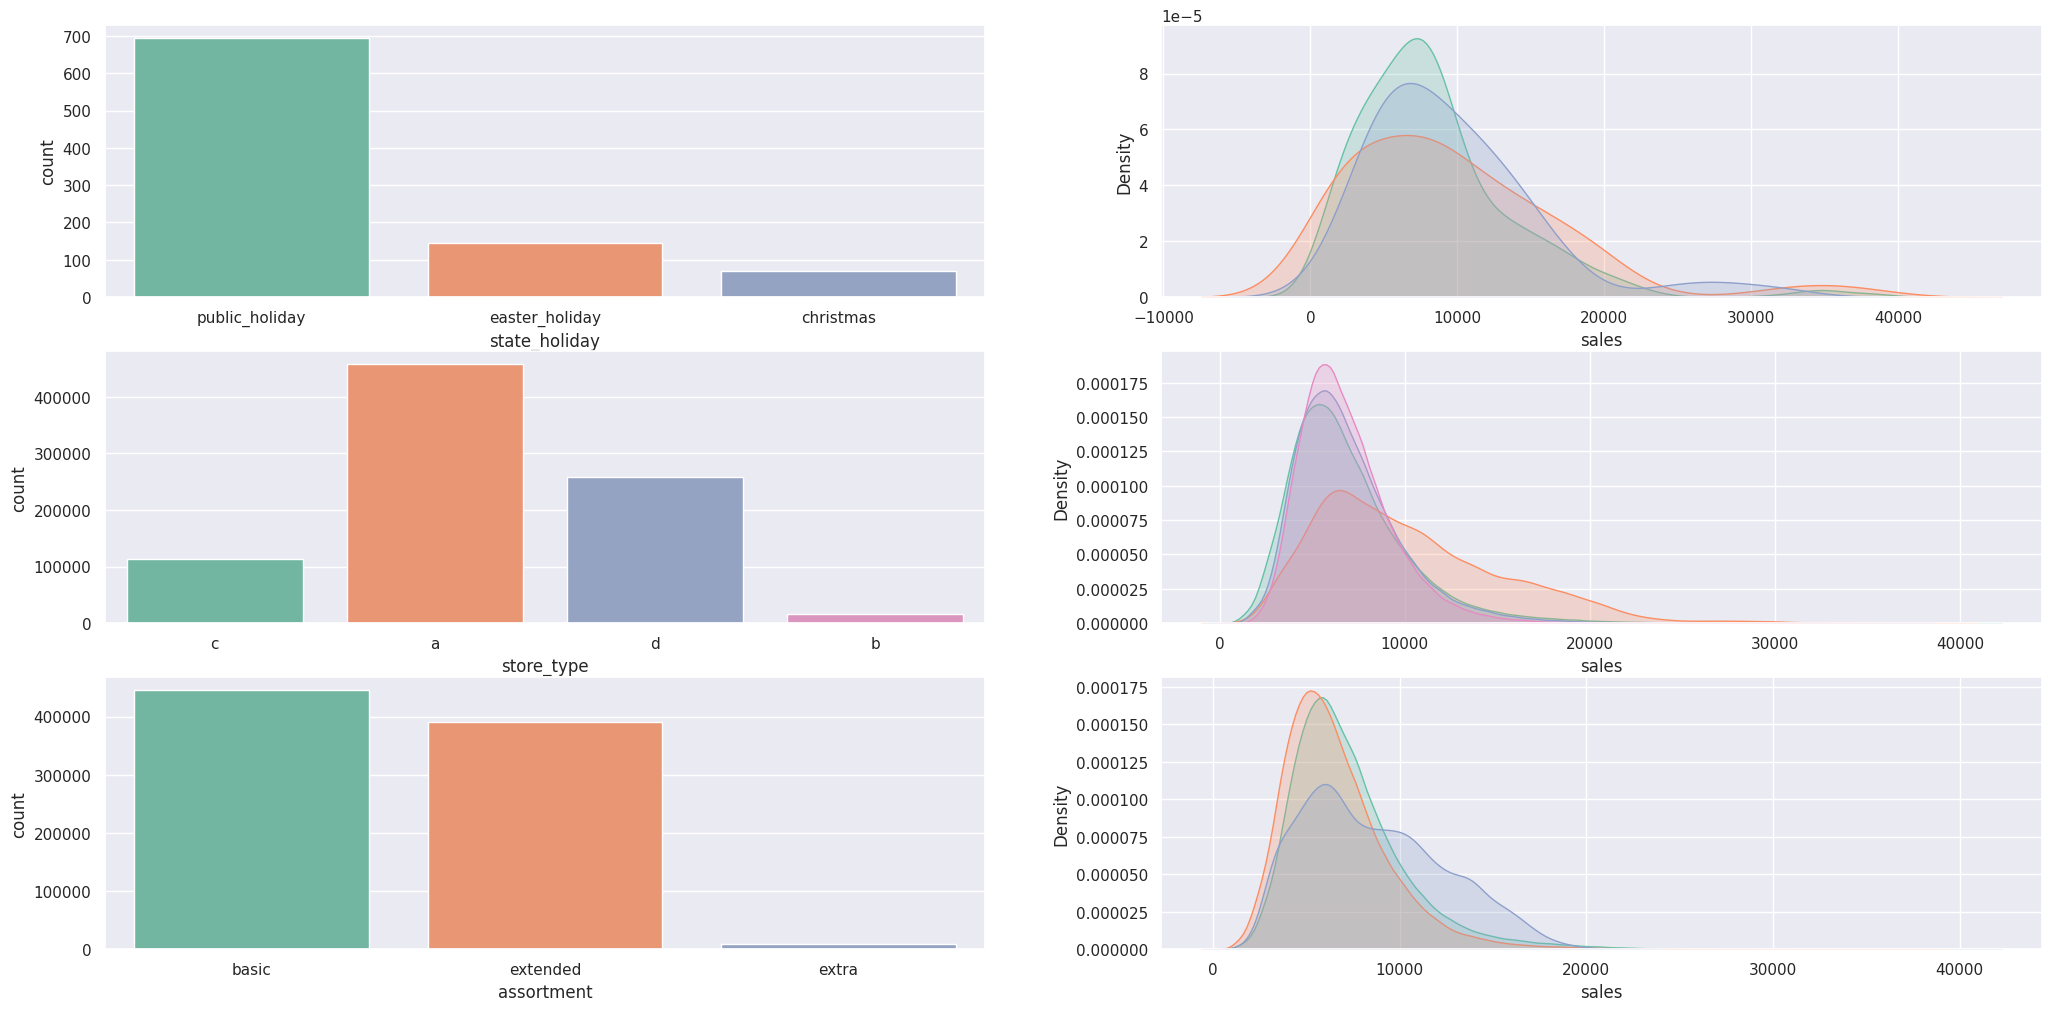

In [ ]:
palette = sns.color_palette('Set2')
# state_holiday
plt.subplot(3,2,1)
a = df4[df4['state_holiday'] != 'regular_day']
sns.countplot(data = a, x= 'state_holiday', hue='state_holiday', palette = palette
 );

plt.subplot(3,2,2)
sns.kdeplot(data = df4[df4['state_holiday'] == 'public_holiday']['sales'], label= 'public_holiday', fill = True, color = palette[0] )
sns.kdeplot(data = df4[df4['state_holiday'] == 'easter_holiday']['sales'], label= 'easter_holiday', fill = True, color = palette[1] )
sns.kdeplot(data = df4[df4['state_holiday'] == 'christmas']['sales'], label= 'christmas', fill = True, color = palette[2]  )

#store_type

plt.subplot(3,2,3)

sns.countplot(data = df4, x= 'store_type', hue = 'store_type', palette = palette
 );

plt.subplot(3,2,4)
sns.kdeplot(data = df4[df4['store_type'] == 'a']['sales'], label= 'a', fill = True, color = palette[0])
sns.kdeplot(data = df4[df4['store_type'] == 'b']['sales'], label= 'b', fill = True, color = palette[1])
sns.kdeplot(data = df4[df4['store_type'] == 'c']['sales'], label= 'c', fill = True, color = palette[2])
sns.kdeplot(data = df4[df4['store_type'] == 'd']['sales'], label= 'd', fill = True, color = palette[3])

#assortment

plt.subplot(3,2,5)

sns.countplot(data = df4, x= 'assortment', palette = palette
 );

plt.subplot(3,2,6)
sns.kdeplot(data = df4[df4['assortment'] == 'extended']['sales'], label= 'extended', fill = True, color = palette[0])
sns.kdeplot(data = df4[df4['assortment'] == 'basic']['sales'], label= 'basic', fill = True, color = palette[1])
sns.kdeplot(data = df4[df4['assortment'] == 'extra']['sales'], label= 'extra', fill = True, color = palette[2])




## 4.2 Análise bivariada

### H1 - Lojas com maior sortimento deveriam vender mais
* Falsa. Lojas com maior sortimento vendem menos

<ipython-input-53-919500b51677>:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x = 'assortment', y= 'sales', data=aux1, palette = palette);
<ipython-input-53-919500b51677>:2: UserWarning: The palette list has more values (8) than needed (3), which may not be intended.
  sns.barplot(x = 'assortment', y= 'sales', data=aux1, palette = palette);


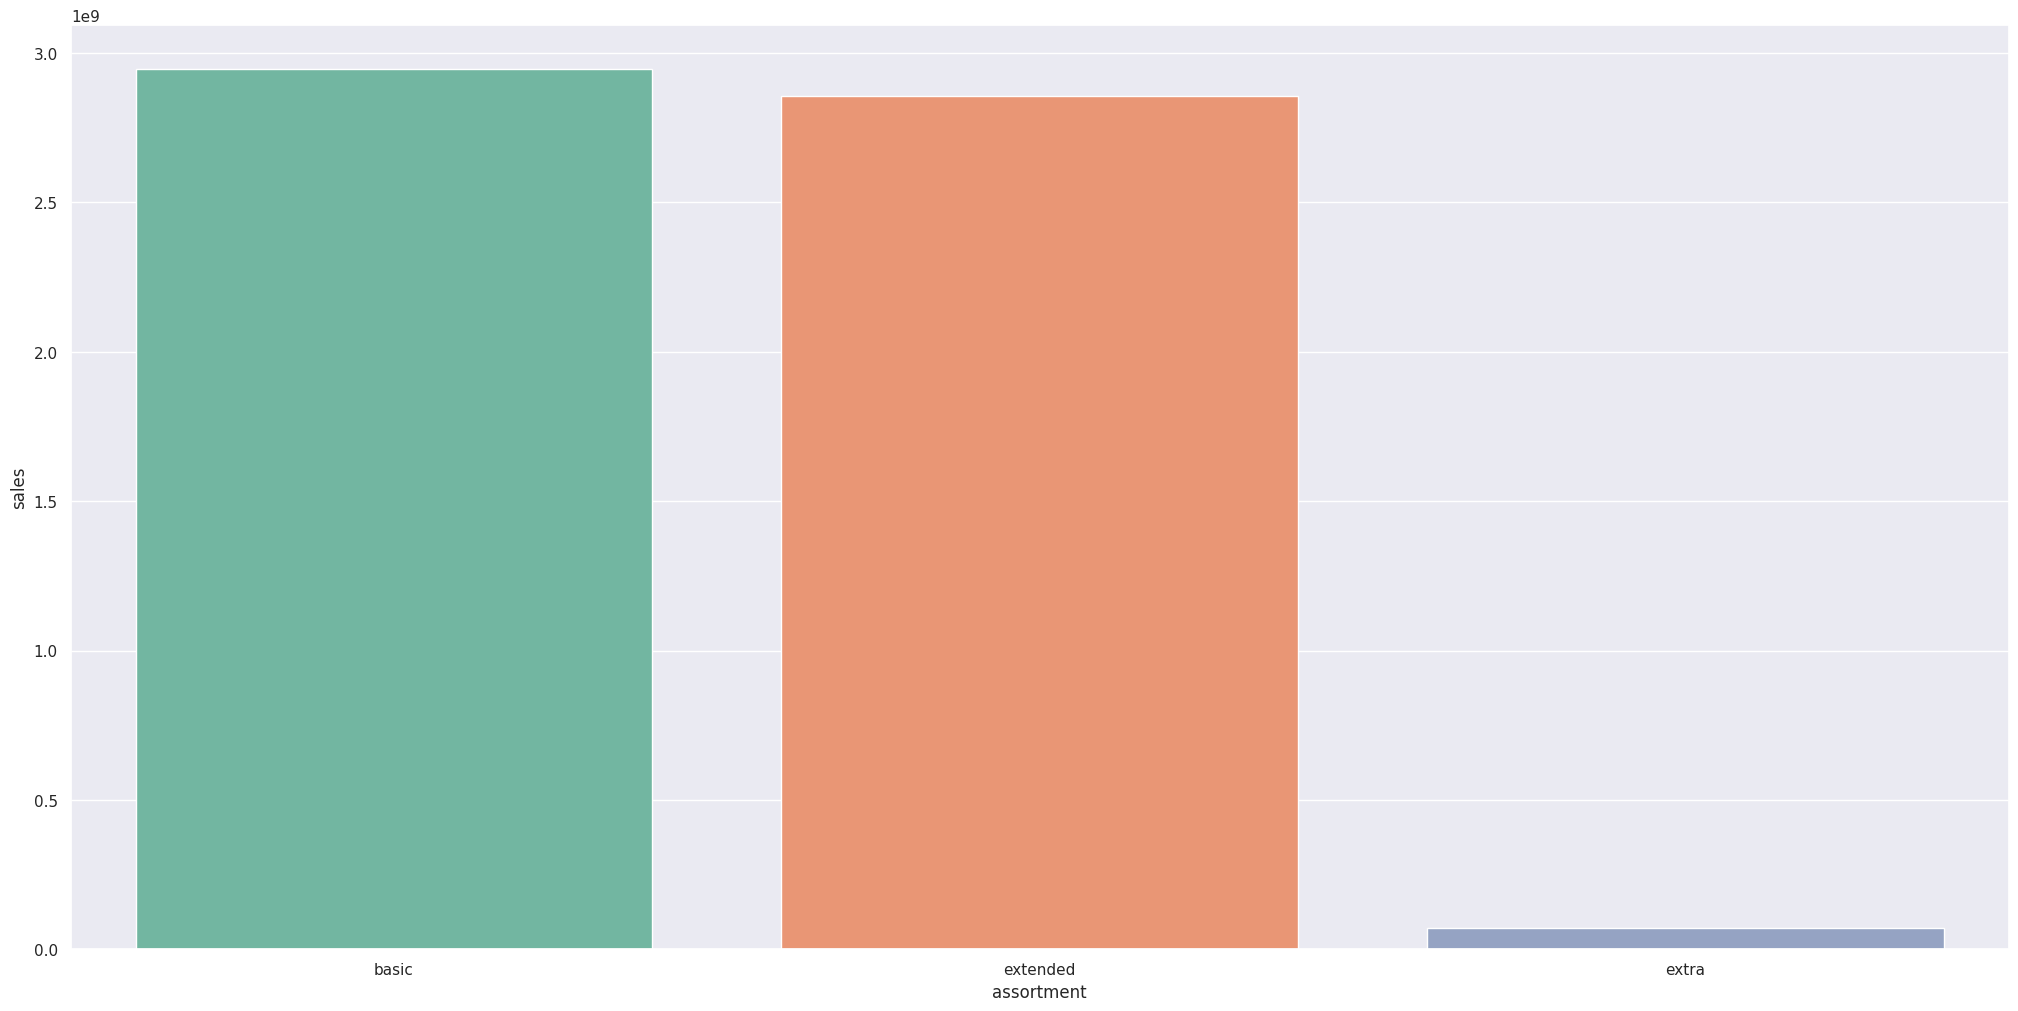

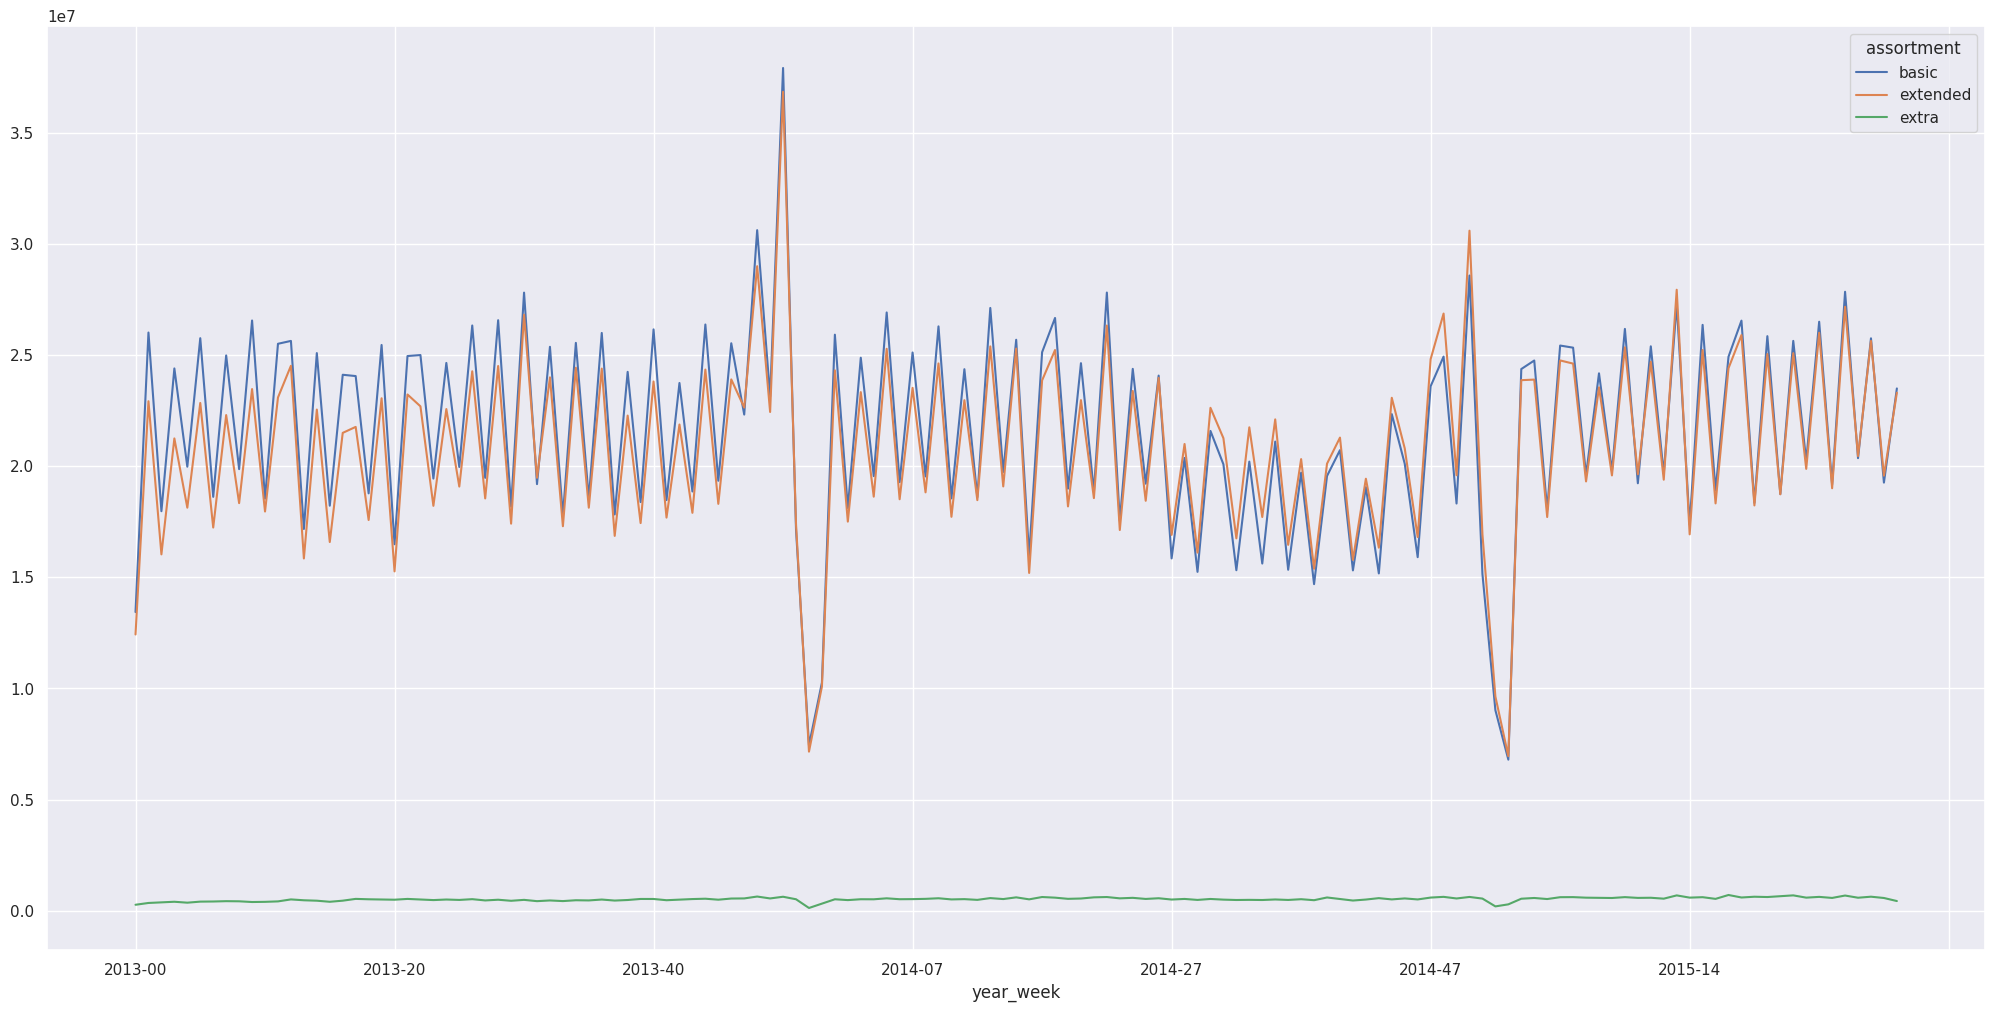

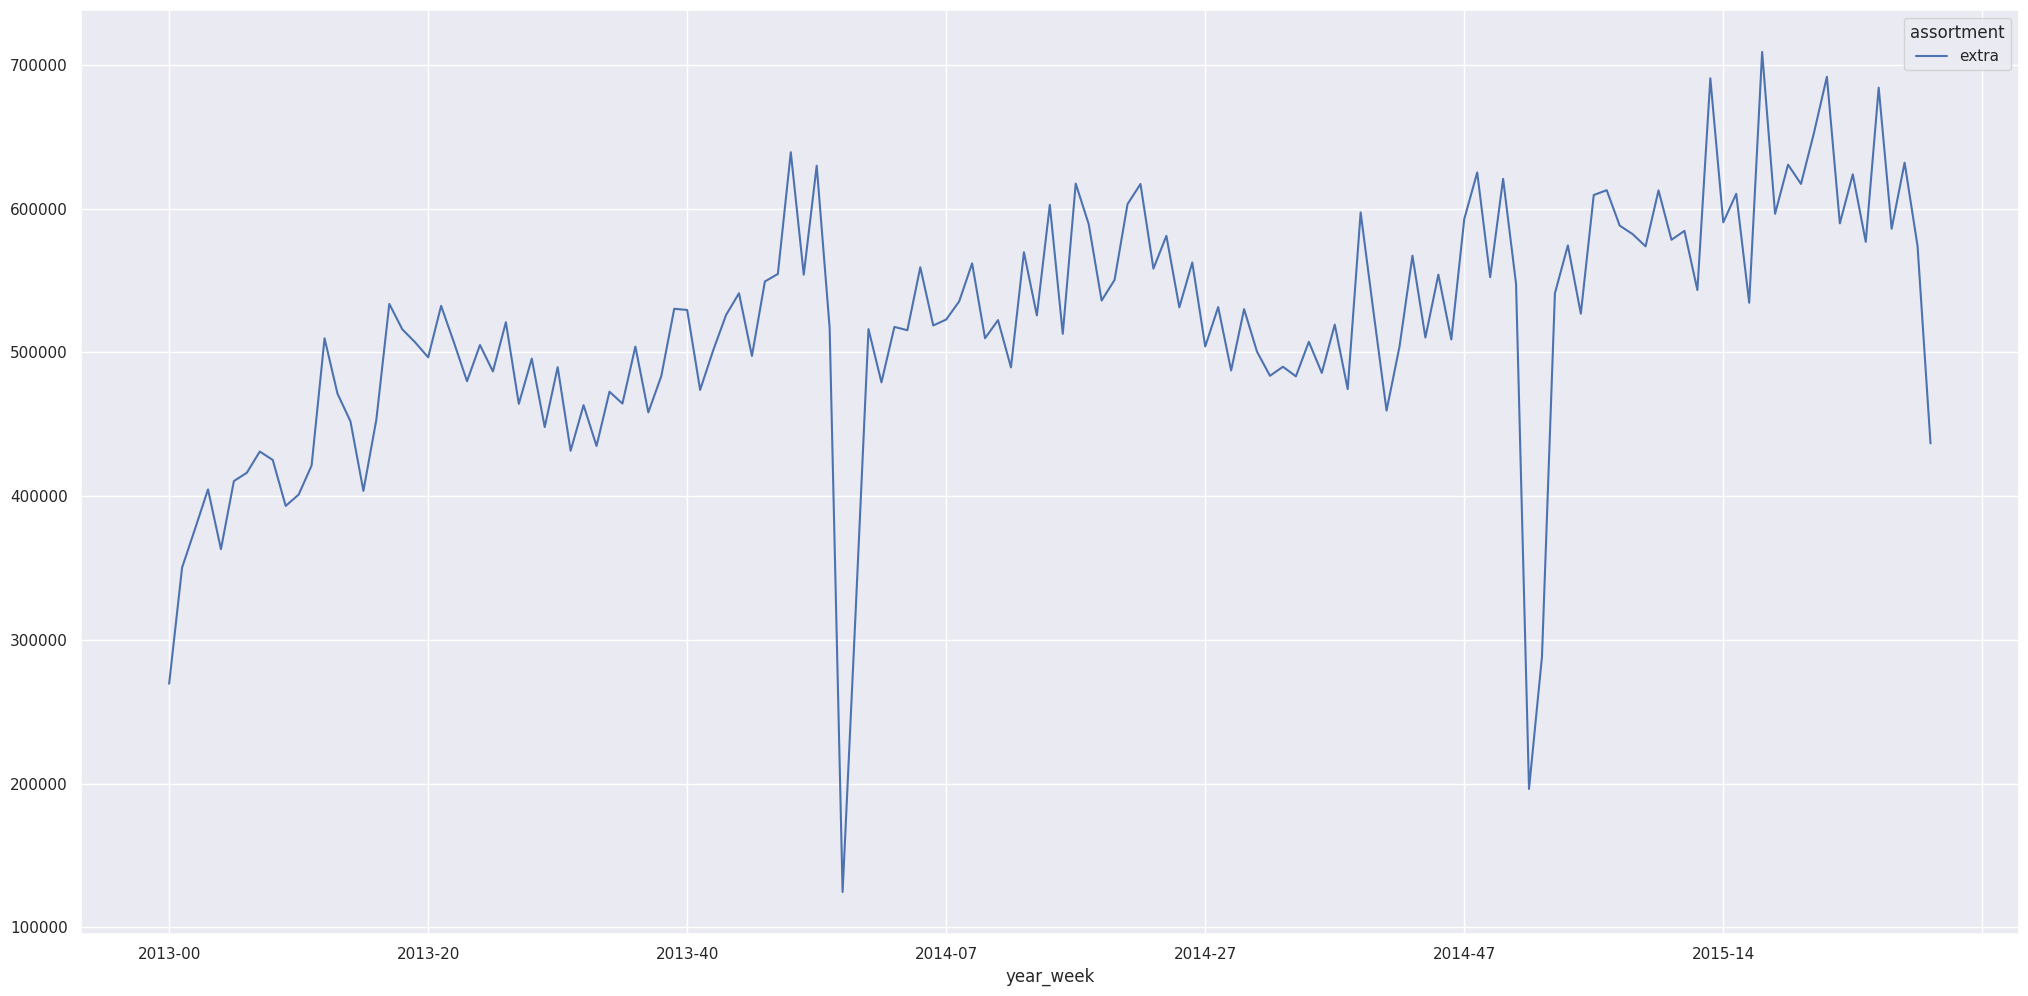

In [ ]:
aux1 = df4[['assortment', 'sales']].groupby('assortment').sum().reset_index()
sns.barplot(x = 'assortment', y= 'sales', data=aux1, palette = palette);

aux2 = df4[['year_week', 'assortment', 'sales']].groupby(['year_week', 'assortment']).sum().reset_index()
aux3 = aux2.pivot(index = 'year_week', columns = 'assortment', values= 'sales')
aux3.plot();

aux4 = aux2[aux2['assortment'] == 'extra']
aux5 = aux4.pivot(index = 'year_week', columns = 'assortment', values= 'sales')
aux5.plot();


### H2 - Lojas com competidores mais próximos deveriam vender menos
* Falsa. Lojas com competidores MAIS PRÓXIMOS vendem MAIS.

<ipython-input-54-dbf9ae57f3fc>:11: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  aux2 = aux1[['competition_distance_binned', 'sales']].groupby('competition_distance_binned').sum().reset_index()
<ipython-input-54-dbf9ae57f3fc>:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x = 'competition_distance_binned', y = 'sales', data = aux2, palette = palette);
<ipython-input-54-dbf9ae57f3fc>:13: UserWarning: 
The palette list has fewer values (8) than needed (19) and will cycle, which may produce an uninterpretable plot.
  sns.barplot(x = 'competition_distance_binned', y = 'sales', data = aux2, palette = palette);


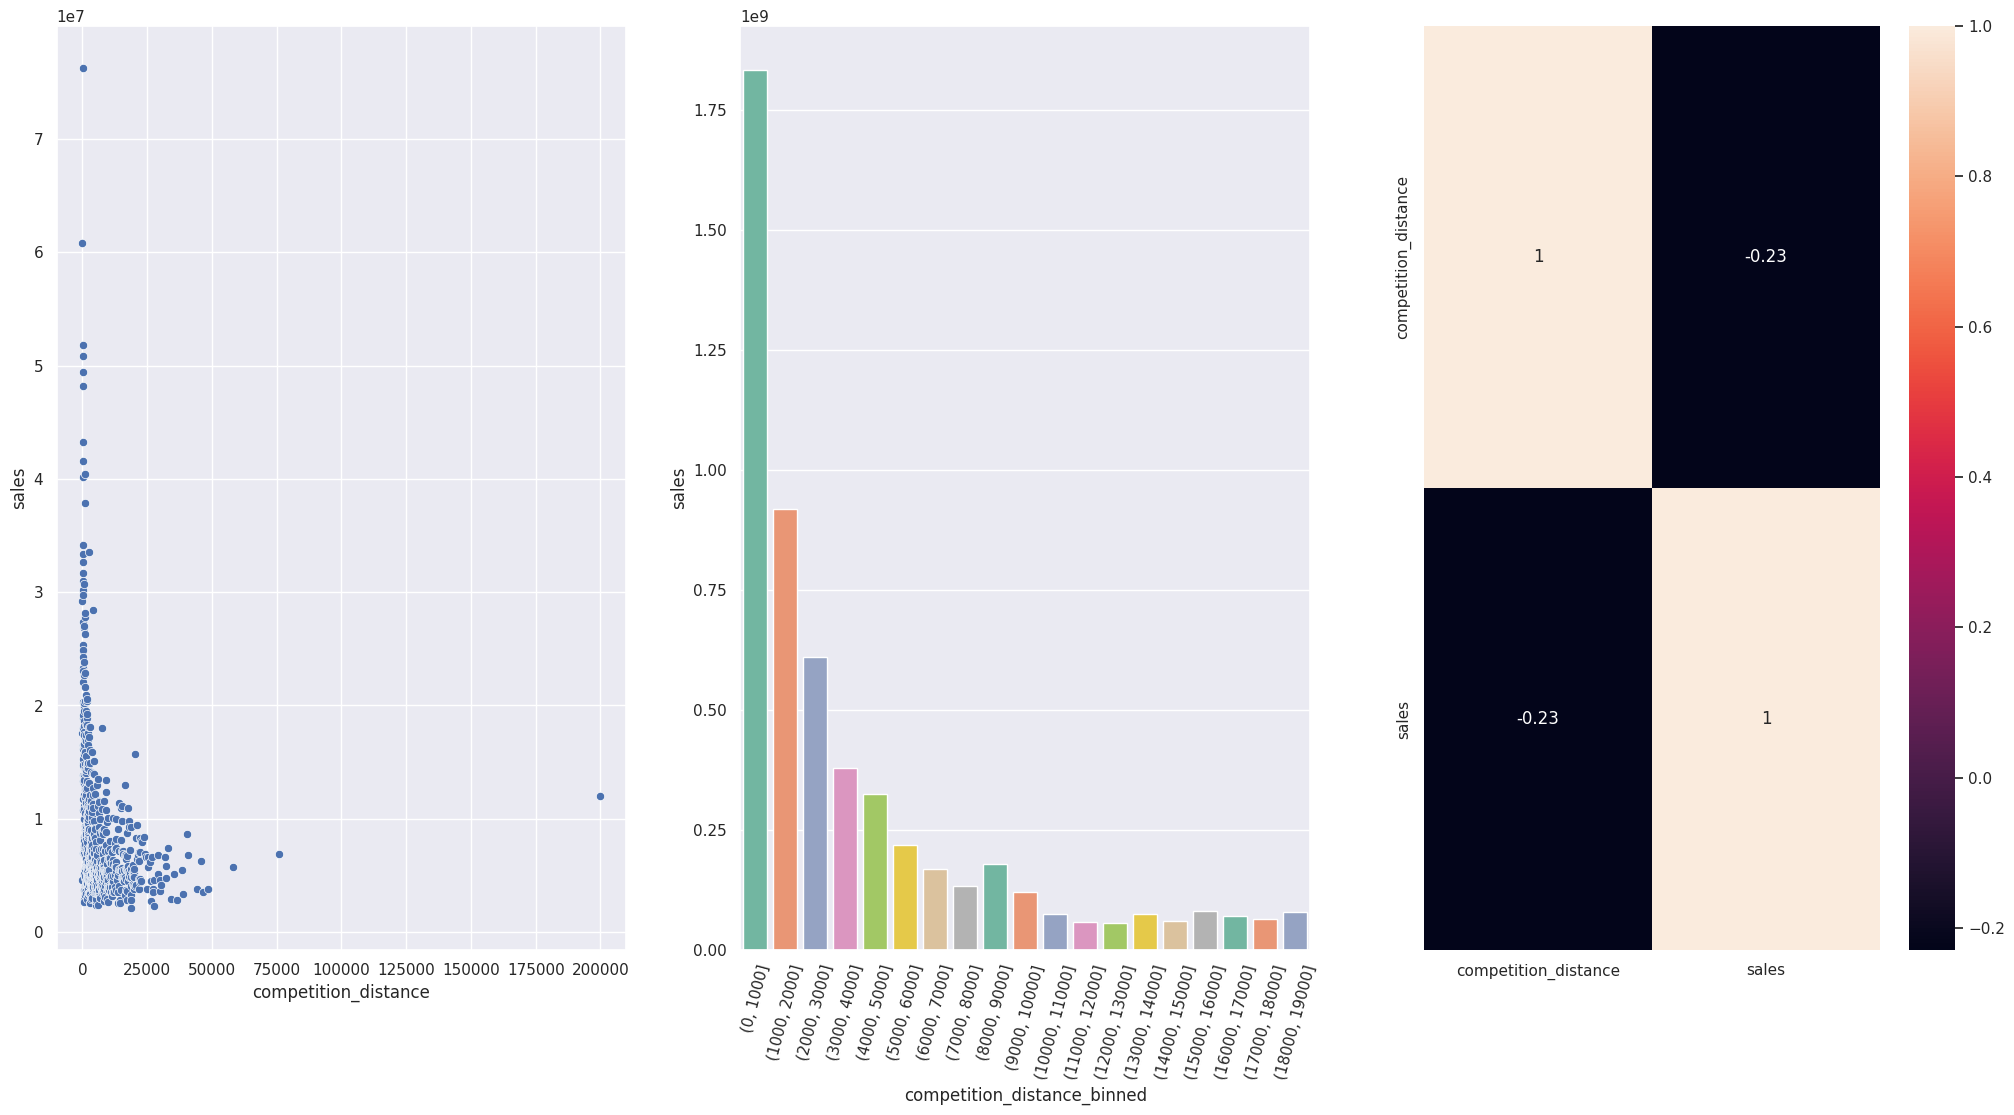

In [ ]:
aux1 = df4[['competition_distance', 'sales']].groupby('competition_distance').sum().reset_index()
plt.subplot(1,3,1)
sns.scatterplot(x = 'competition_distance', y = 'sales',data = aux1)

plt.subplot(1,3,2)
#aux1 = df4[['competition_distance', 'sales']].groupby('competition_distance').sum().reset_index()

bins = list(np.arange(0,20000, 1000))

aux1['competition_distance_binned'] = pd.cut(aux1['competition_distance'], bins = bins)
aux2 = aux1[['competition_distance_binned', 'sales']].groupby('competition_distance_binned').sum().reset_index()

sns.barplot(x = 'competition_distance_binned', y = 'sales', data = aux2, palette = palette);
plt.xticks(rotation = 75);

plt.subplot(1,3,3)
sns.heatmap(aux1[['competition_distance', 'sales']].corr(method = 'pearson'), annot = True);

<Axes: xlabel='competition_distance', ylabel='sales'>

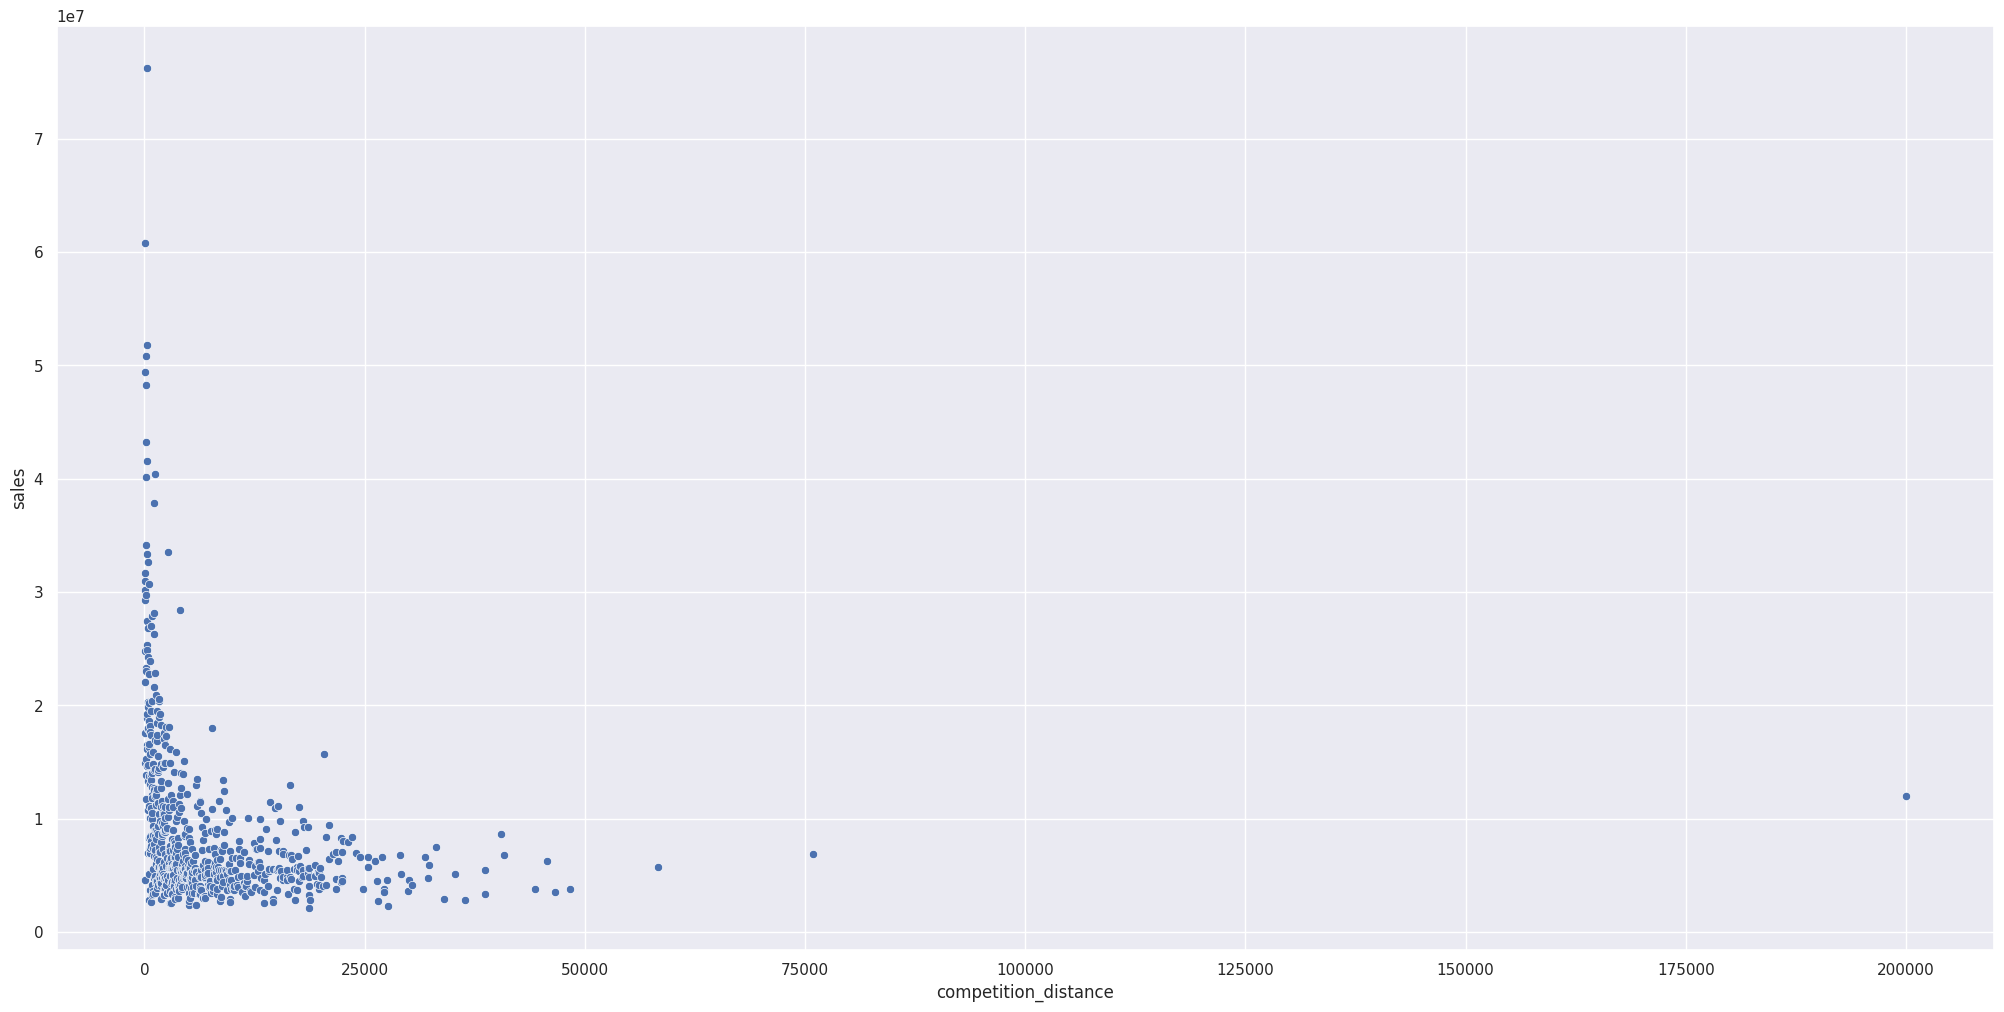

In [ ]:
aux1 = df4[['competition_distance', 'sales']].groupby('competition_distance').sum().reset_index()
sns.scatterplot(x = 'competition_distance', y = 'sales',data = aux1)

### H3. Lojas com competidores abertos há mais tempo vendem mais.
* Falsa. Lojas com competidores há mais tempo vendem menos

<ipython-input-56-abba997bbd42>:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x= 'competition_time_month', y= 'sales', data= aux2, palette = palette);
<ipython-input-56-abba997bbd42>:4: UserWarning: 
The palette list has fewer values (8) than needed (150) and will cycle, which may produce an uninterpretable plot.
  sns.barplot(x= 'competition_time_month', y= 'sales', data= aux2, palette = palette);


(2.5, -0.5)

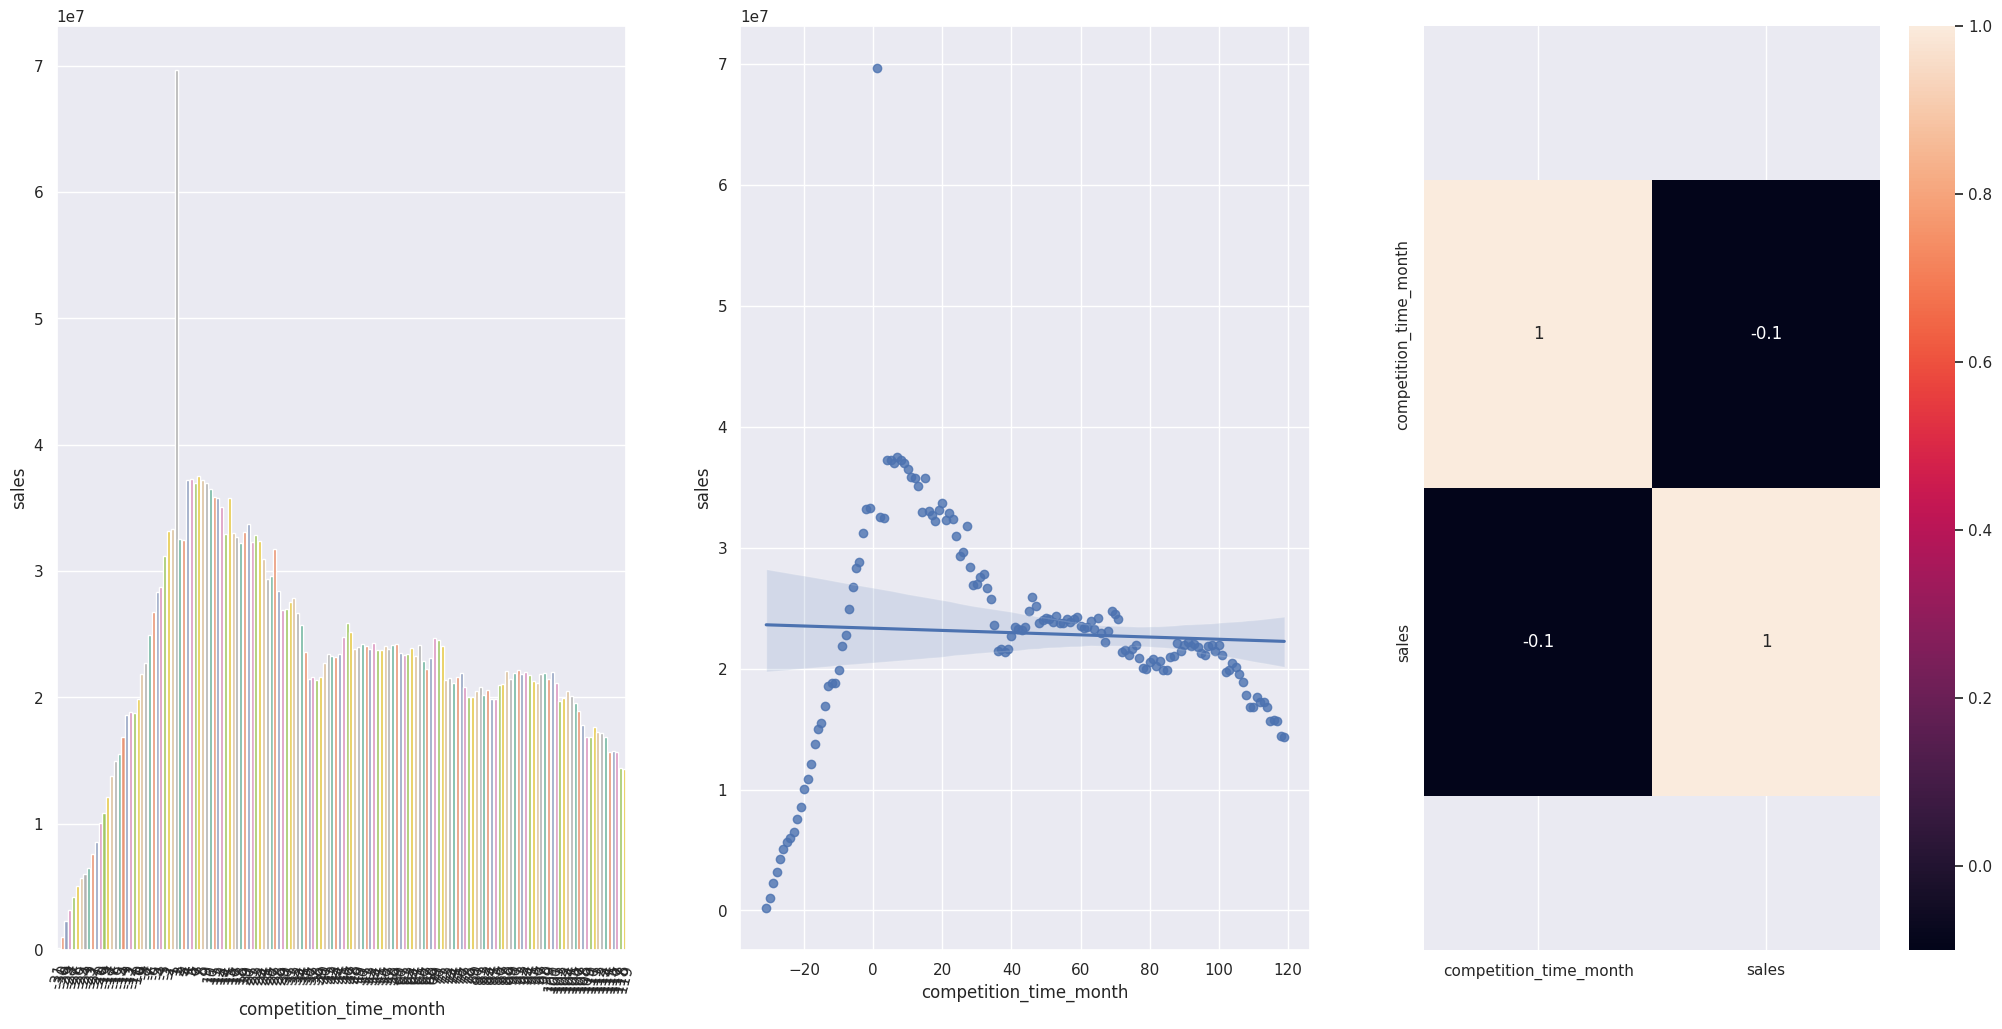

In [ ]:
aux1 = df4[['competition_time_month', 'sales']].groupby('competition_time_month').sum().reset_index()
aux2=aux1[(aux1['competition_time_month'] < 120) & (aux1['competition_time_month'] != 0)]
plt.subplot(1,3,1)
sns.barplot(x= 'competition_time_month', y= 'sales', data= aux2, palette = palette);
plt.xticks(rotation = 75);
plt.subplot(1,3,2)
sns.regplot(x= 'competition_time_month', y= 'sales', data= aux2);
plt.subplot(1,3,3)
x= sns.heatmap(aux1.corr(method='pearson'), annot= True);
bottom, top = x.get_ylim()
x.set_ylim(bottom + 0.5, top-0.5)


### H4. Lojas com promoções ativas há mais tempo deveriam vender mais
* Falsa. Lojas com promoções ativas por mais tempo vendem menos, depois de um certo período de promoção.

<ipython-input-57-9803a1868bb3>:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x= 'promo_time_week', y= 'sales', data= aux2, palette = palette);
<ipython-input-57-9803a1868bb3>:6: UserWarning: 
The palette list has fewer values (8) than needed (313) and will cycle, which may produce an uninterpretable plot.
  sns.barplot(x= 'promo_time_week', y= 'sales', data= aux2, palette = palette);
<ipython-input-57-9803a1868bb3>:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x= 'promo_time_week', y= 'sales', data= aux3, palette = palette);
<ipython-input-57-9803a1868bb3>:14: UserWarning: 
The palette list has fewer values (8) than needed (126) and will cycle, which may produce an uninterpretable 

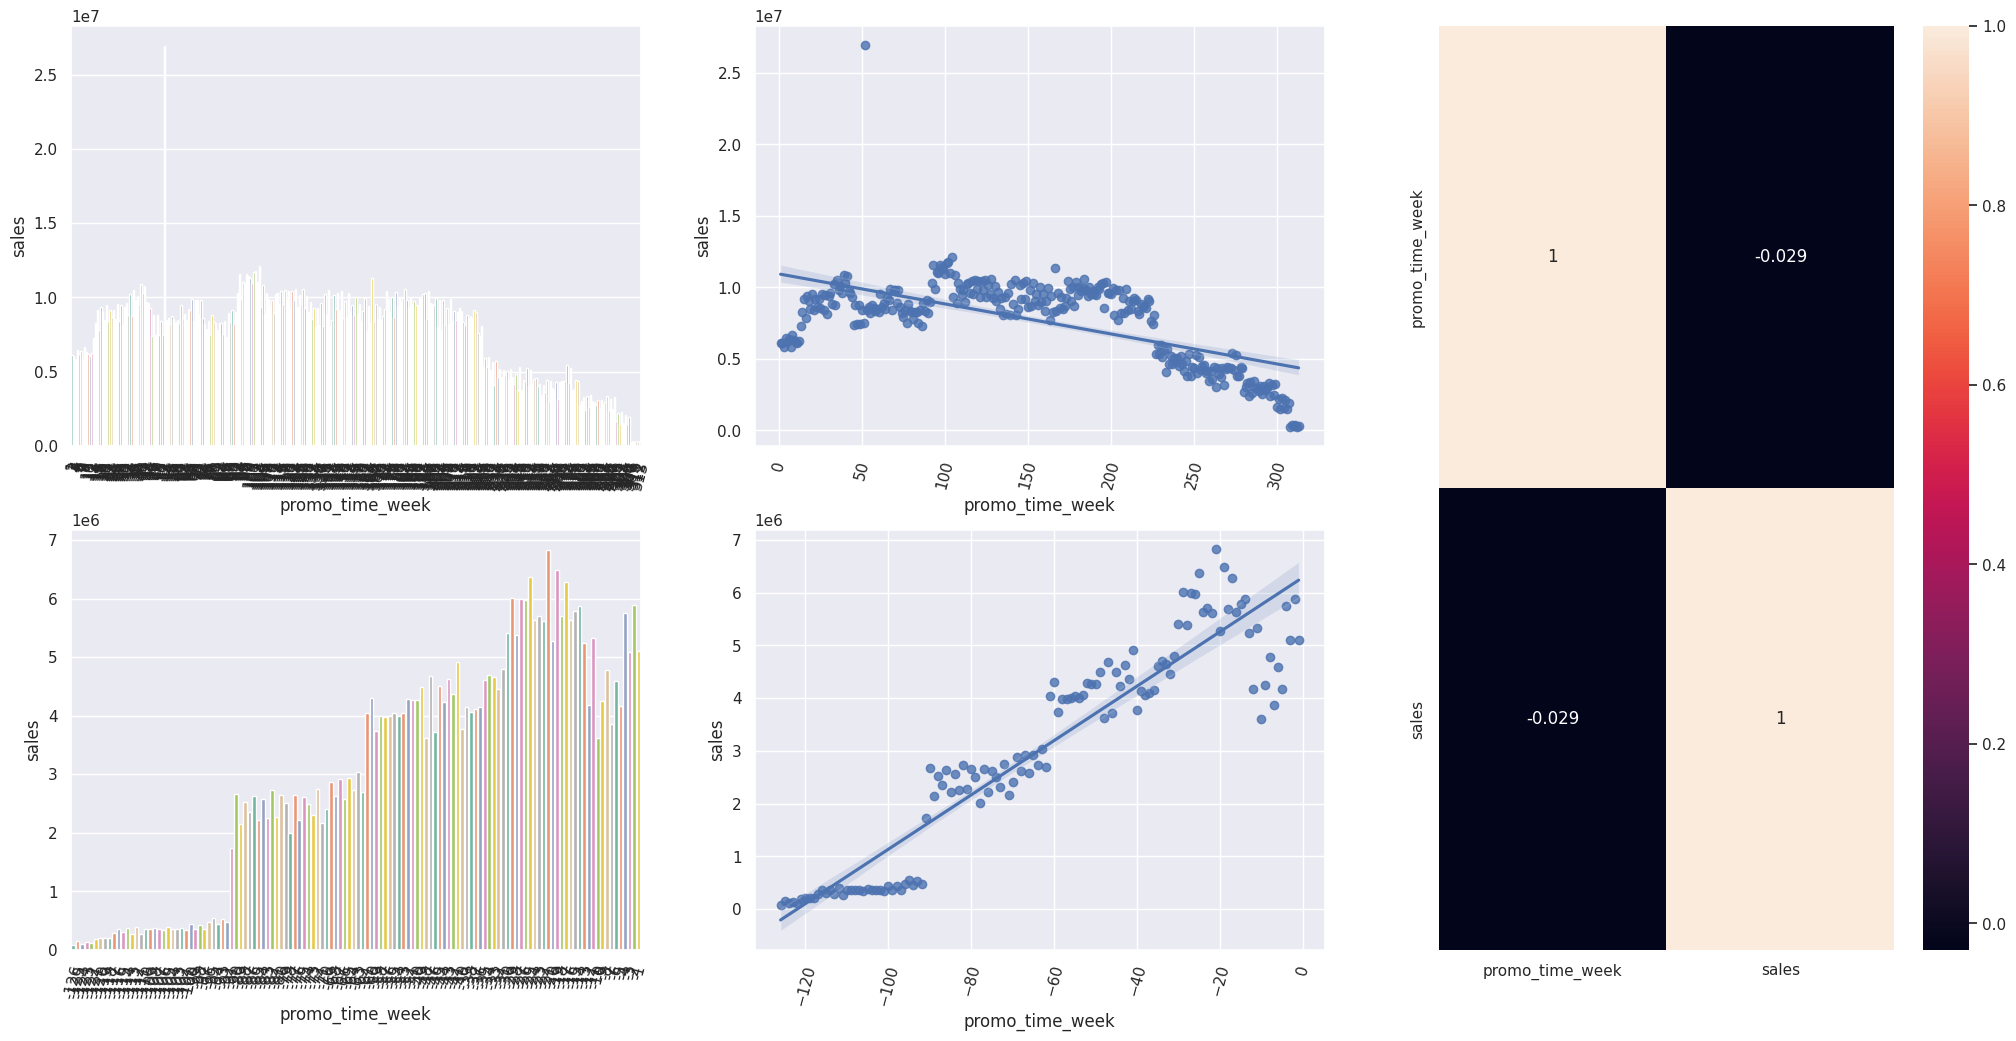

In [ ]:
aux1 = df4[['promo_time_week', 'sales']].groupby('promo_time_week').sum().reset_index()
grid = GridSpec(2,3)

plt.subplot(grid[0,0])
aux2 = aux1[aux1['promo_time_week'] > 0] # promo extendida
sns.barplot(x= 'promo_time_week', y= 'sales', data= aux2, palette = palette);
plt.xticks(rotation = 75);
plt.subplot(grid[0,1])
sns.regplot(x= 'promo_time_week', y= 'sales', data= aux2);
plt.xticks(rotation = 75);

plt.subplot(grid[1,0])
aux3 = aux1[aux1['promo_time_week'] < 0] # promo regular
sns.barplot(x= 'promo_time_week', y= 'sales', data= aux3, palette = palette);
plt.xticks(rotation = 75);
plt.subplot(grid[1,1])
sns.regplot(x= 'promo_time_week', y= 'sales', data= aux3);
plt.xticks(rotation = 75);
plt.subplot(grid[:,2])
sns.heatmap(aux1.corr(method= 'pearson'),annot=True);

### <s> H5. Lojas com mais dias de promoção deveriam vender mais.</s>


### H7. Lojas com mais promoções consecutivas deveriam vender mais.
* Falsa. Lojas com 2 promoções ativas vendem menos

In [ ]:
df4[['promo', 'promo2', 'sales']].groupby(['promo', 'promo2']).sum().reset_index()

,promo,promo2,sales
0,0,0,1482612096
1,0,1,1289362241
2,1,0,1628930532
3,1,1,1472275754


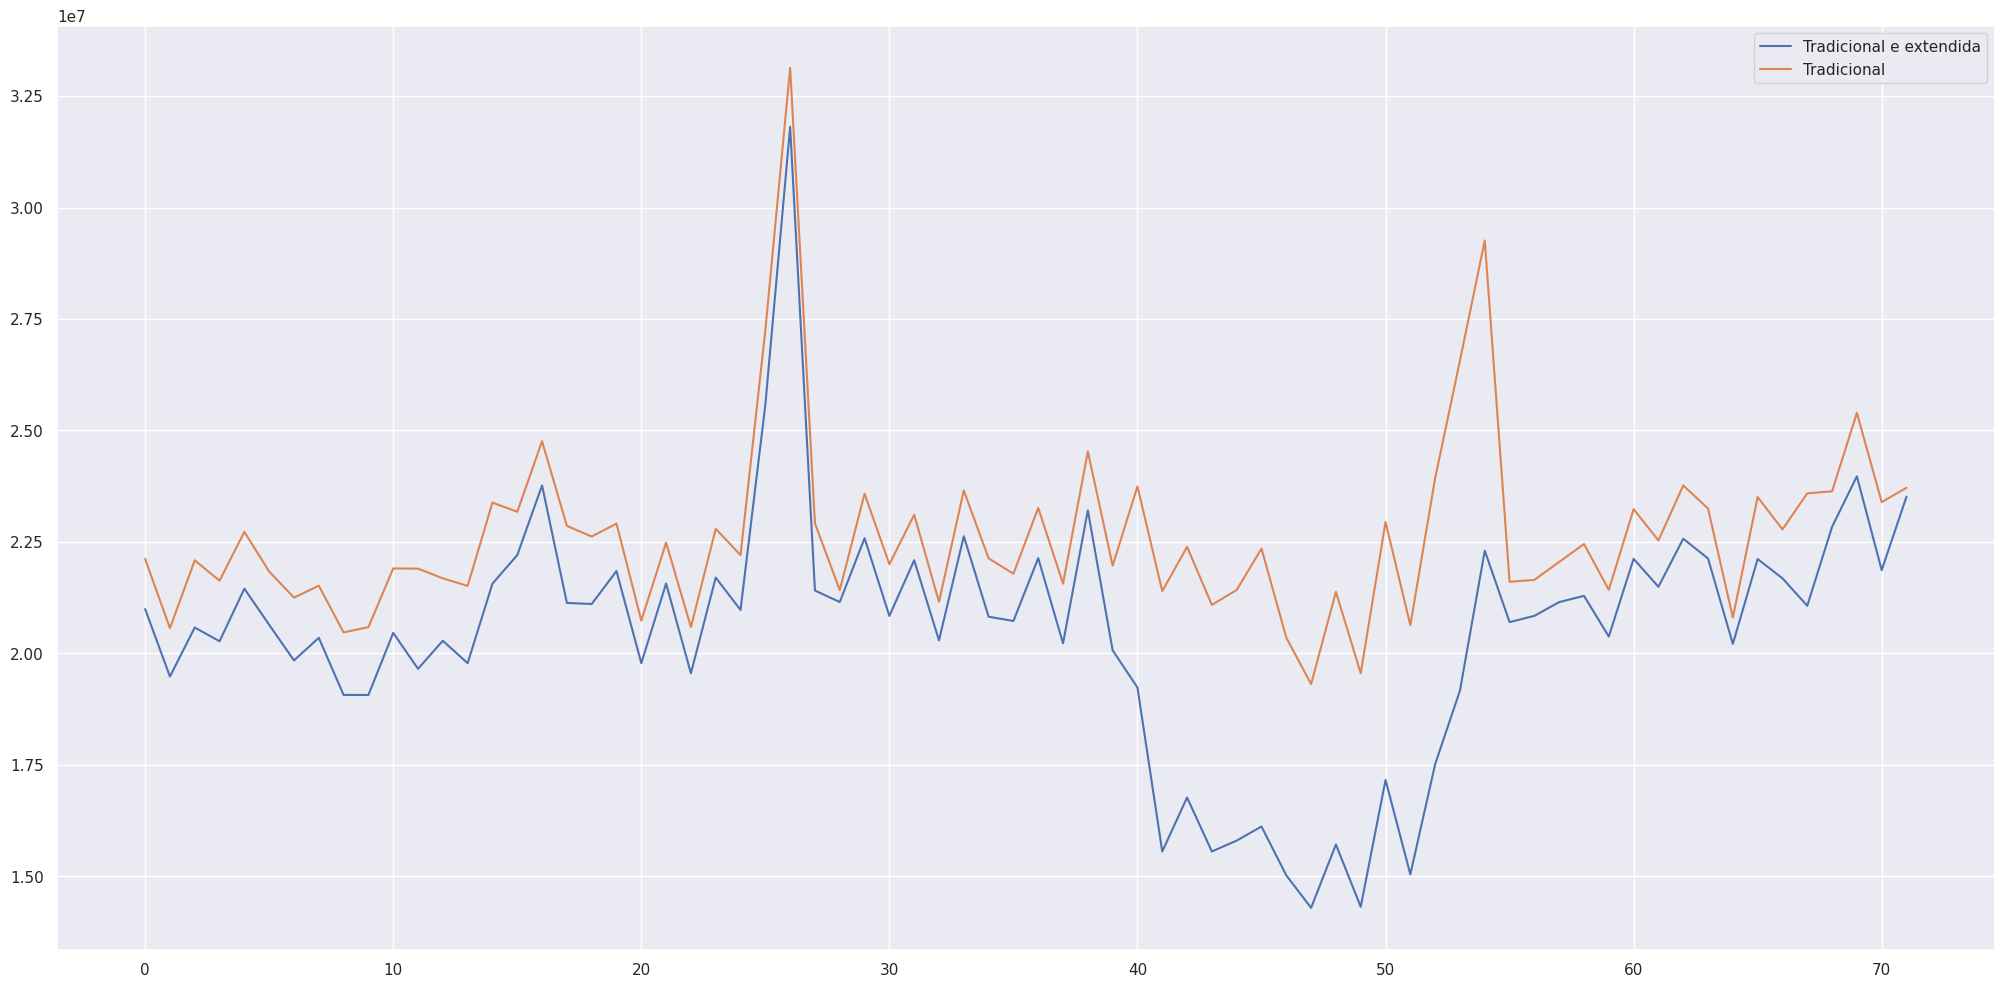

In [ ]:
aux1 = df4[(df4['promo'] == 1) & (df4['promo2'] == 1)][['year_week', 'sales']].groupby('year_week').sum().reset_index()
ax = aux1.plot()

aux2 = df4[(df4['promo'] == 1) & (df4['promo2'] == 0)][['year_week', 'sales']].groupby('year_week').sum().reset_index()
aux2.plot(ax=ax)
ax.legend(labels = ['Tradicional e extendida', 'Tradicional'])

### H8. Lojas abertas durante o feriado de Natal deveriam vender mais.
* Falsa. No Natal as lojas vendem menos em relação a outros feriados.


<ipython-input-60-0f3ab812c3f7>:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x= 'state_holiday', y= 'sales', data= aux1, palette = palette);
<ipython-input-60-0f3ab812c3f7>:4: UserWarning: The palette list has more values (8) than needed (3), which may not be intended.
  sns.barplot(x= 'state_holiday', y= 'sales', data= aux1, palette = palette);
<ipython-input-60-0f3ab812c3f7>:7: UserWarning: The palette list has more values (8) than needed (3), which may not be intended.
  sns.barplot(x= 'year', y= 'sales', data= aux2, hue= 'state_holiday', palette = palette);


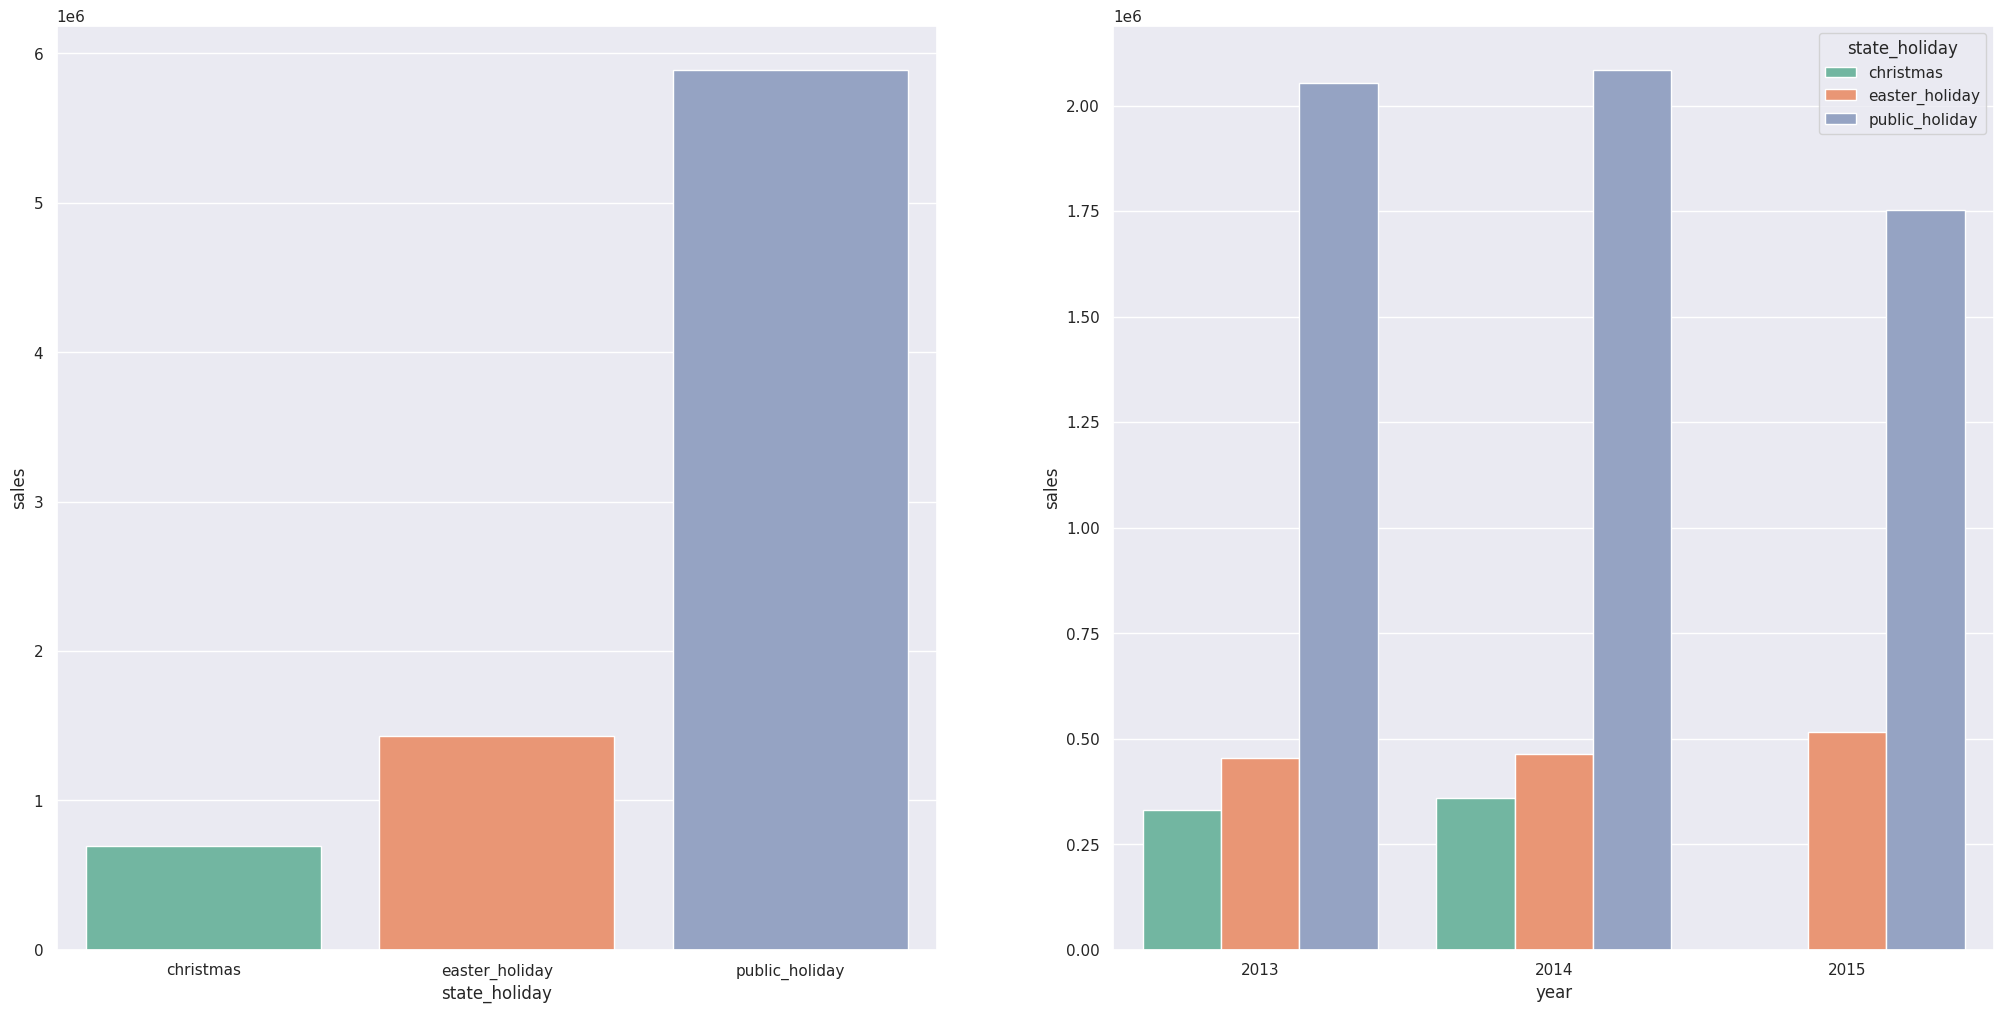

In [ ]:
aux = df4[df4['state_holiday'] != 'regular_day']
aux1 = aux[['state_holiday', 'sales']].groupby('state_holiday').sum().reset_index()
plt.subplot(1,2,1)
sns.barplot(x= 'state_holiday', y= 'sales', data= aux1, palette = palette);
aux2 = aux[['year', 'state_holiday', 'sales']].groupby(['year', 'state_holiday']).sum().reset_index()
plt.subplot(1,2,2)
sns.barplot(x= 'year', y= 'sales', data= aux2, hue= 'state_holiday', palette = palette);

### H9. Lojas deveriam vender mais ao longo dos anos
* Falsa. Lojas vendem menos ao longo dos anos.

<ipython-input-61-551e3a7e3614>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x= 'year', y= 'sales', data= aux1, palette=palette);
<ipython-input-61-551e3a7e3614>:3: UserWarning: The palette list has more values (8) than needed (3), which may not be intended.
  sns.barplot(x= 'year', y= 'sales', data= aux1, palette=palette);


<Axes: >

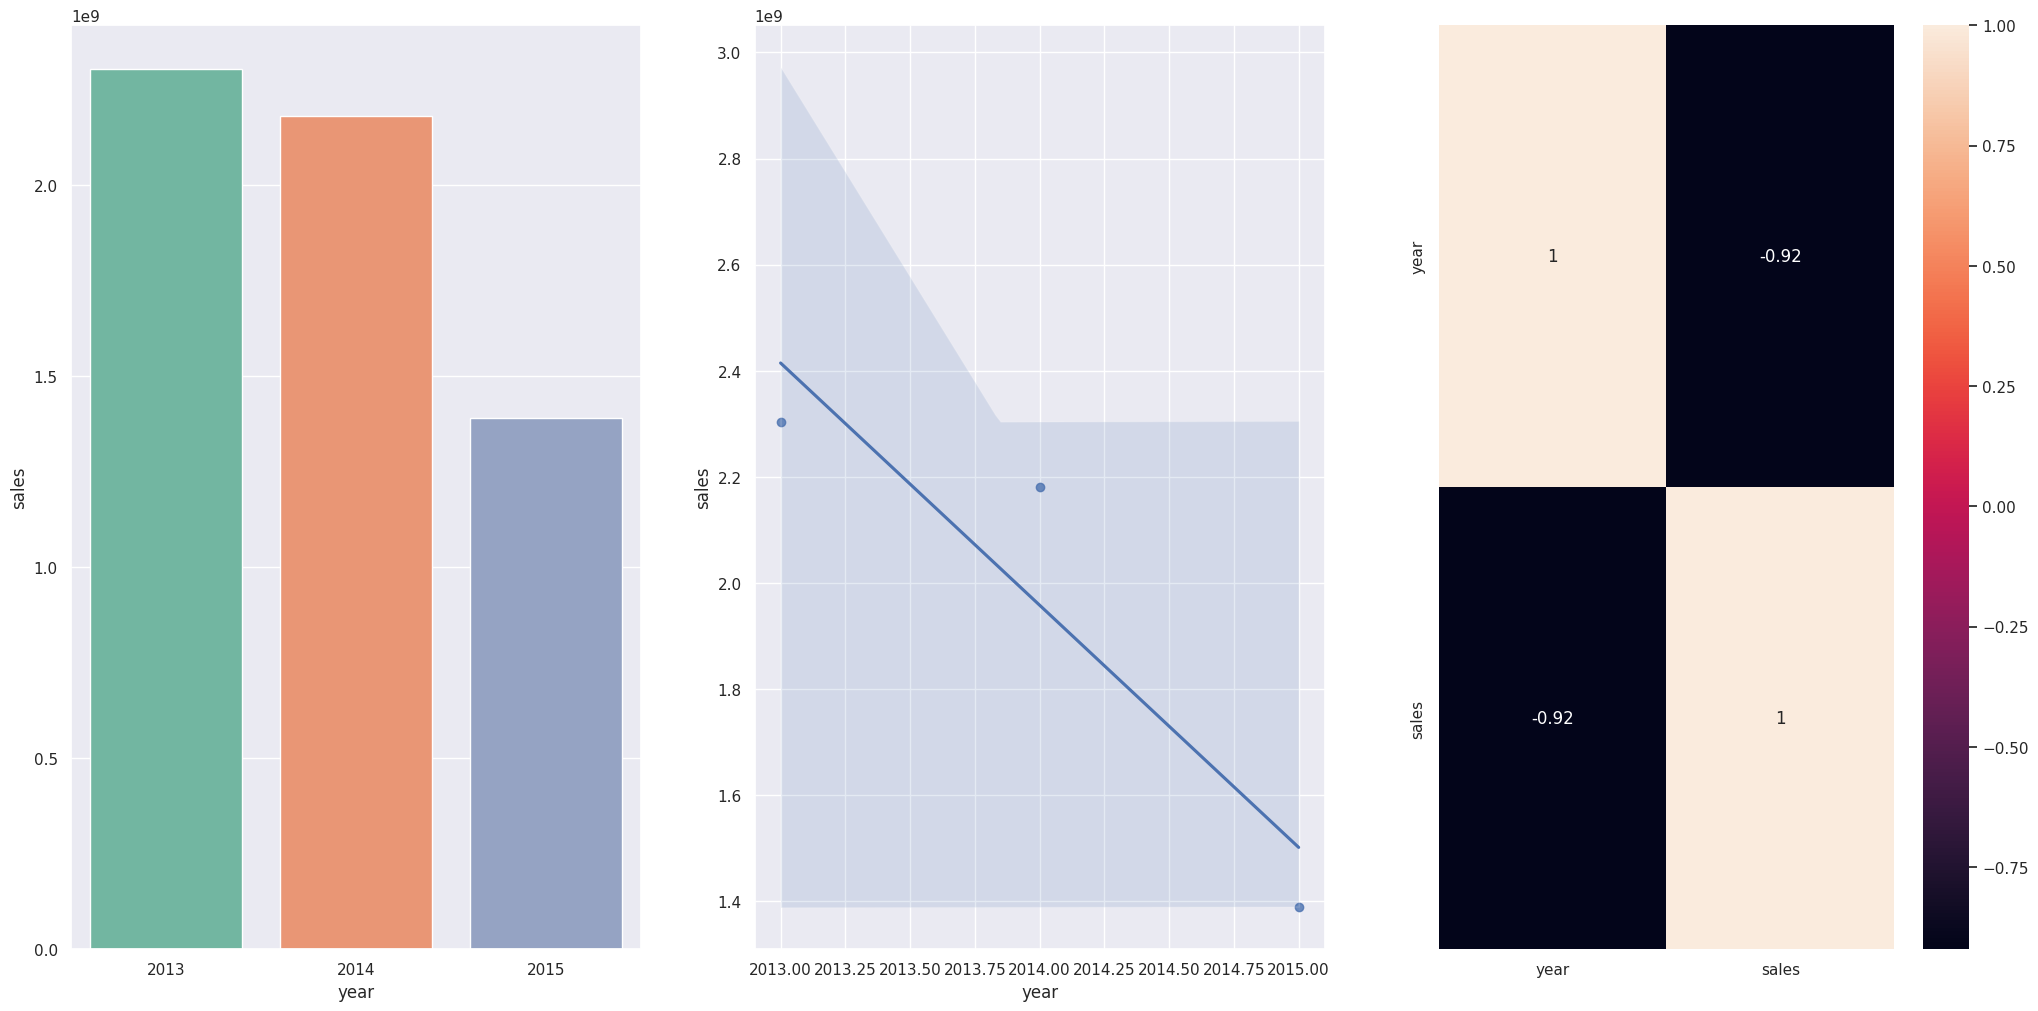

In [ ]:
aux1 = df4[['year', 'sales']].groupby('year').sum().reset_index()
plt.subplot(1,3,1)
sns.barplot(x= 'year', y= 'sales', data= aux1, palette=palette);
plt.subplot(1,3,2)
sns.regplot(x= 'year', y= 'sales', data= aux1);
plt.subplot(1,3,3)
sns.heatmap(aux1.corr(method='pearson'), annot = True)

### H10. Lojas deveriam vender mais no segundo semestre do ano.
* Falsa. Lojas vendem menos no segundo semestre do ano.

<ipython-input-62-b46b8ac53f69>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x= 'month', y= 'sales', data= aux1, palette=palette);
<ipython-input-62-b46b8ac53f69>:3: UserWarning: 
The palette list has fewer values (8) than needed (12) and will cycle, which may produce an uninterpretable plot.
  sns.barplot(x= 'month', y= 'sales', data= aux1, palette=palette);


<Axes: >

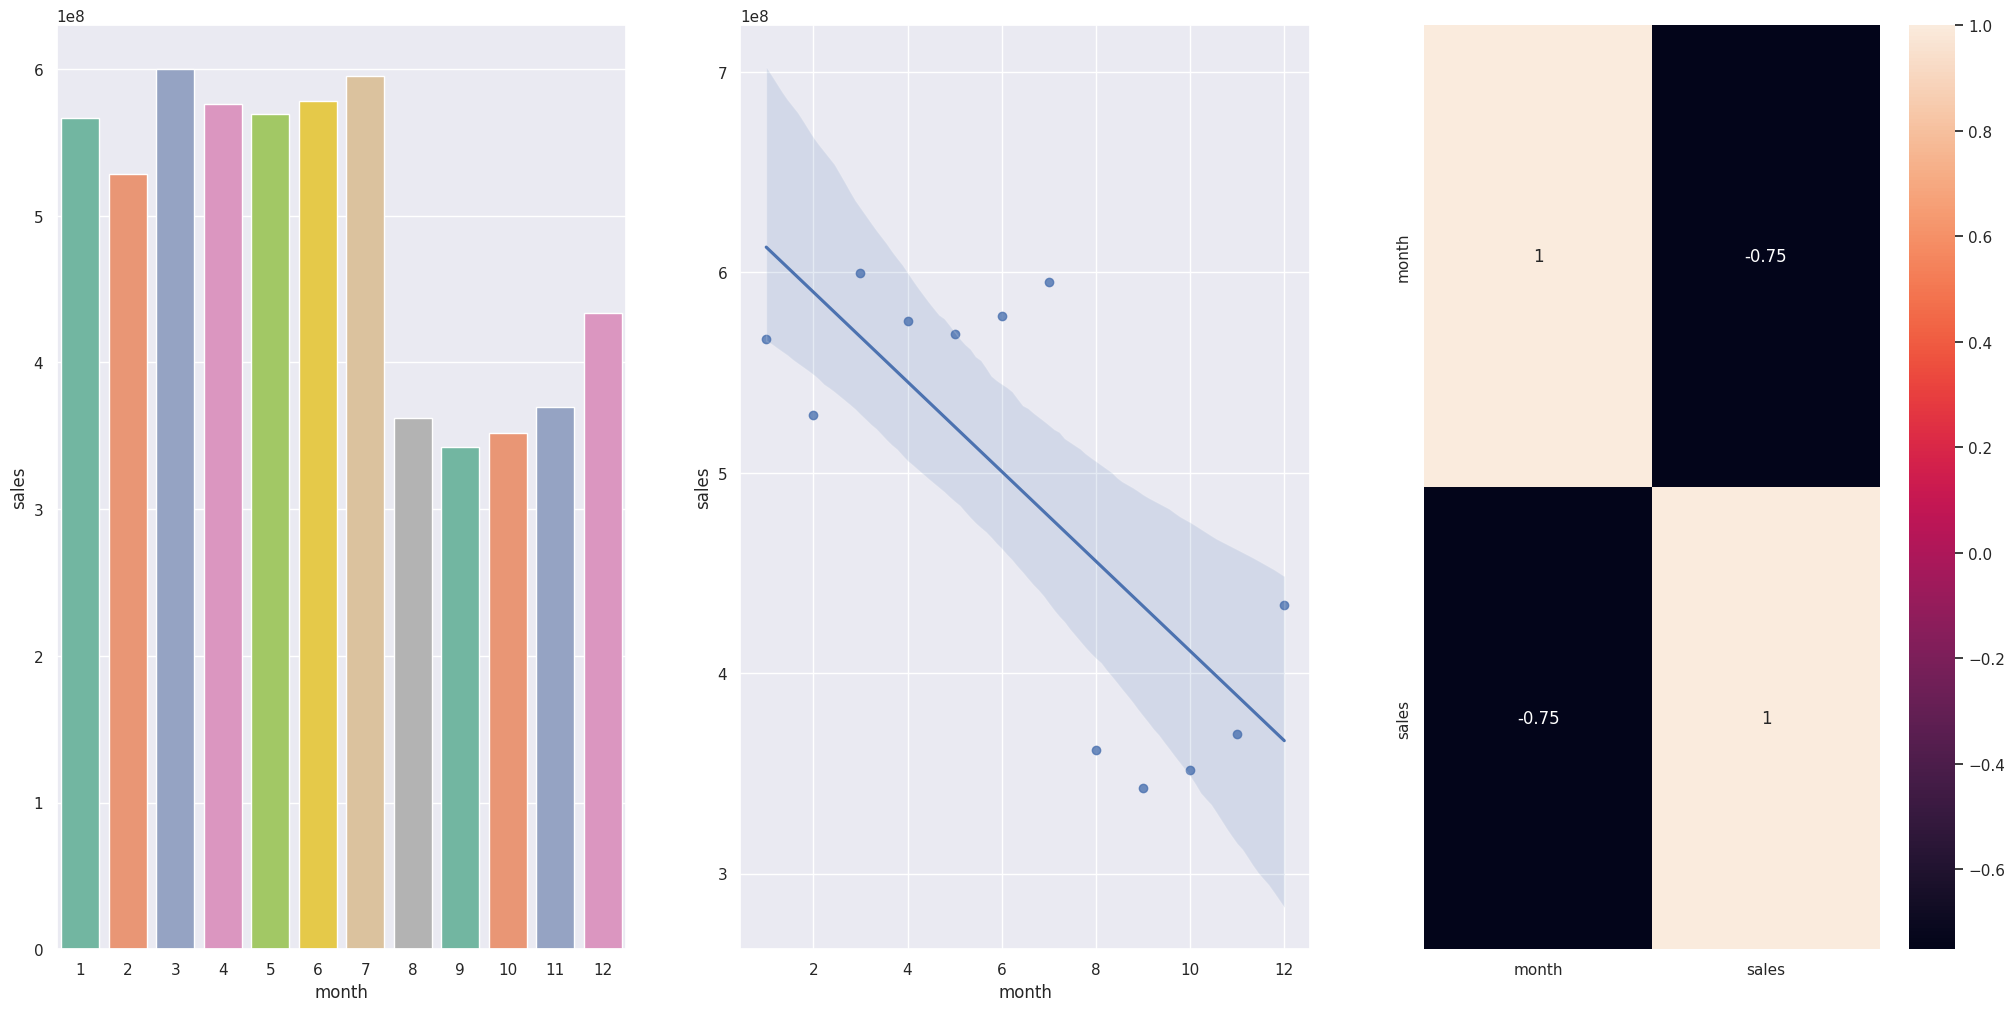

In [ ]:
aux1 = df4[['month', 'sales']].groupby('month').sum().reset_index()
plt.subplot(1,3,1)
sns.barplot(x= 'month', y= 'sales', data= aux1, palette=palette);
plt.subplot(1,3,2)
sns.regplot(x= 'month', y= 'sales', data= aux1);
plt.subplot(1,3,3)
sns.heatmap(aux1.corr(method='pearson'), annot = True)

### H11. Lojas deveriam vender mais após o dia 10 de cada mês.
* Verdadeira. O volume de vendas é maior após o dia 10

<ipython-input-63-7841bec03c11>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x= 'day', y= 'sales', data= aux1, palette=palette);
<ipython-input-63-7841bec03c11>:3: UserWarning: 
The palette list has fewer values (8) than needed (31) and will cycle, which may produce an uninterpretable plot.
  sns.barplot(x= 'day', y= 'sales', data= aux1, palette=palette);
<ipython-input-63-7841bec03c11>:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x= 'before_after', y= 'sales', data=aux2, palette=palette)
<ipython-input-63-7841bec03c11>:11: UserWarning: The palette list has more values (8) than needed (2), which may not be intended.
  sns.barplot(x= 'before_after', y= 'sales', data=aux2, palette=p

<Axes: xlabel='before_after', ylabel='sales'>

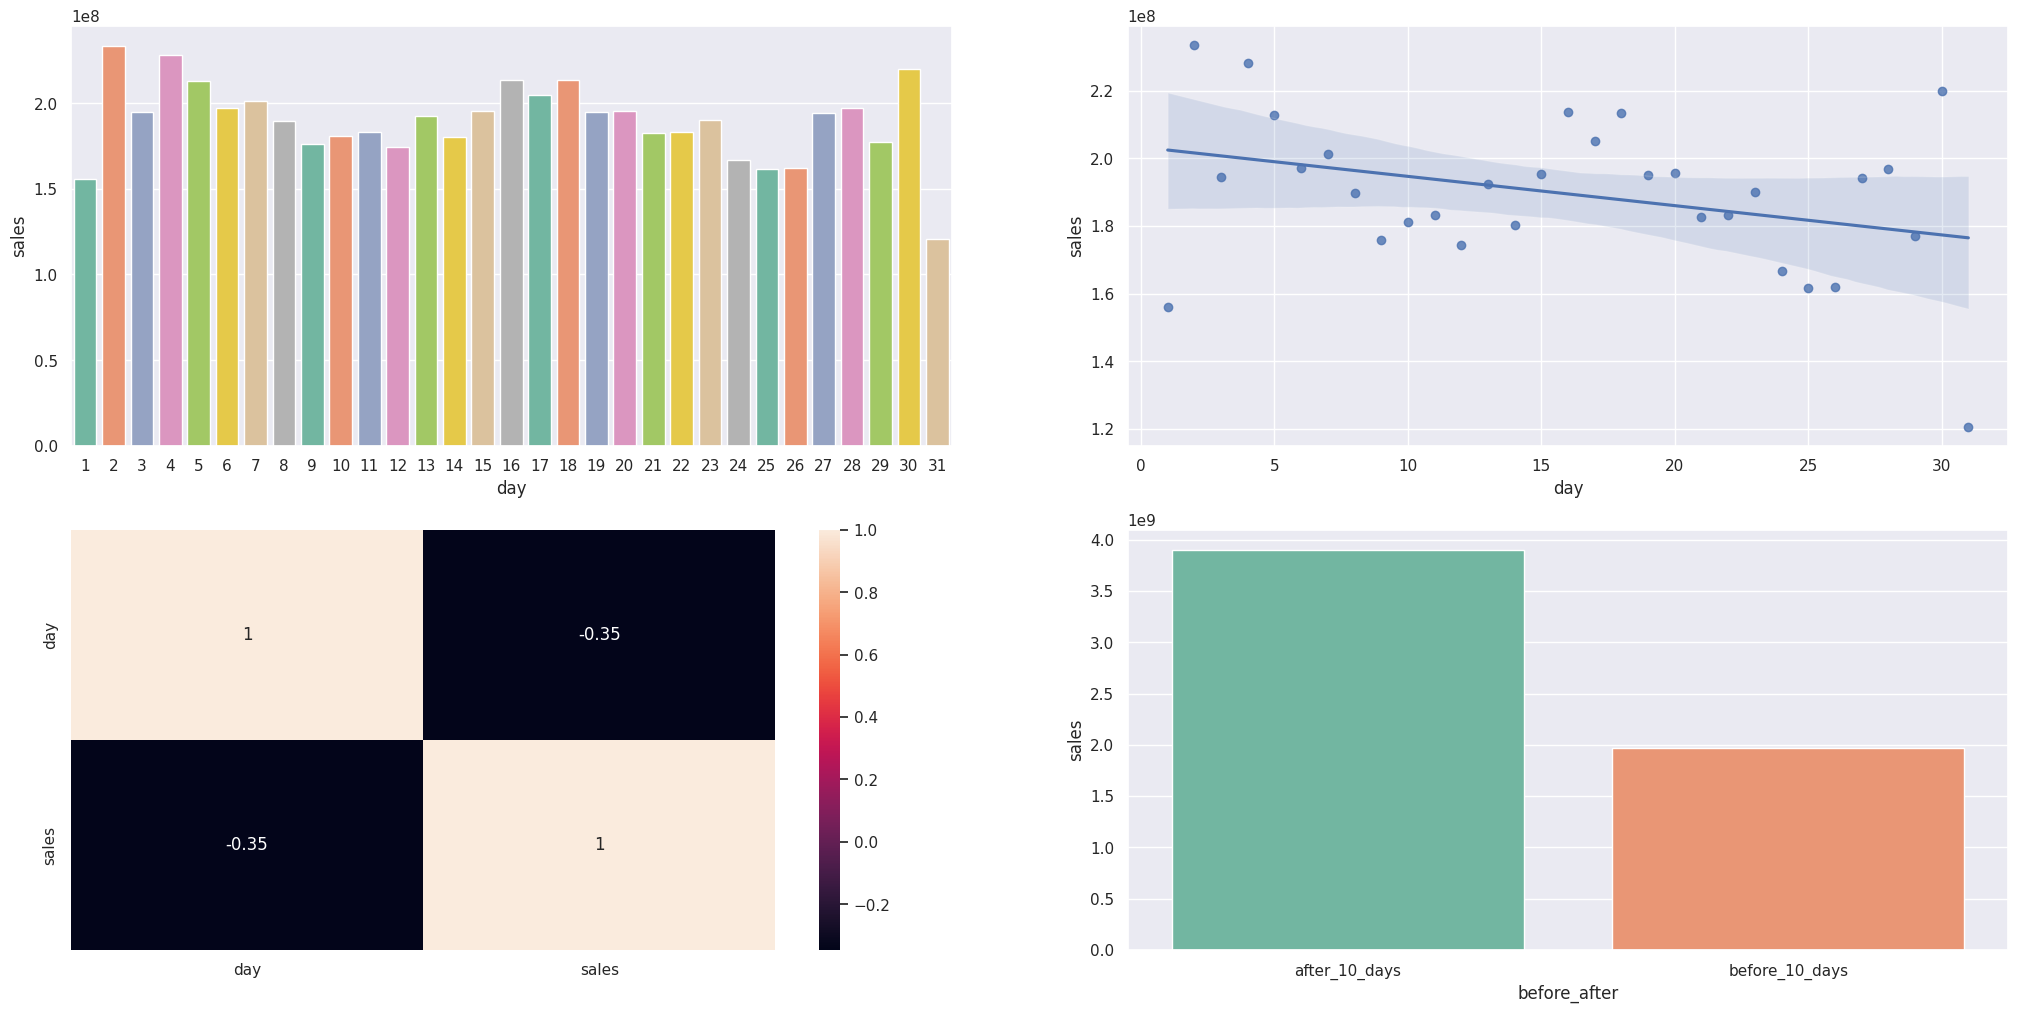

In [ ]:
aux1 = df4[['day', 'sales']].groupby('day').sum().reset_index()
plt.subplot(2,2,1)
sns.barplot(x= 'day', y= 'sales', data= aux1, palette=palette);
plt.subplot(2,2,2)
sns.regplot(x= 'day', y= 'sales', data= aux1);
plt.subplot(2,2,3)
sns.heatmap(aux1.corr(method='pearson'), annot = True)
plt.subplot(2,2,4)
aux1['before_after'] = aux1['day'].apply(lambda x: 'before_10_days' if x <= 10 else 'after_10_days')
aux2 = aux1[['before_after', 'sales']].groupby('before_after').sum().reset_index()
sns.barplot(x= 'before_after', y= 'sales', data=aux2, palette=palette)

### H12. Lojas deveriam vender menos aos finais de semana
* Verdadeira. Lojas vendem menos aos finais de semana.

<ipython-input-64-02164dd14c4e>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x= 'day_of_week', y= 'sales', data= aux1, palette=palette);
<ipython-input-64-02164dd14c4e>:3: UserWarning: The palette list has more values (8) than needed (7), which may not be intended.
  sns.barplot(x= 'day_of_week', y= 'sales', data= aux1, palette=palette);


<Axes: >

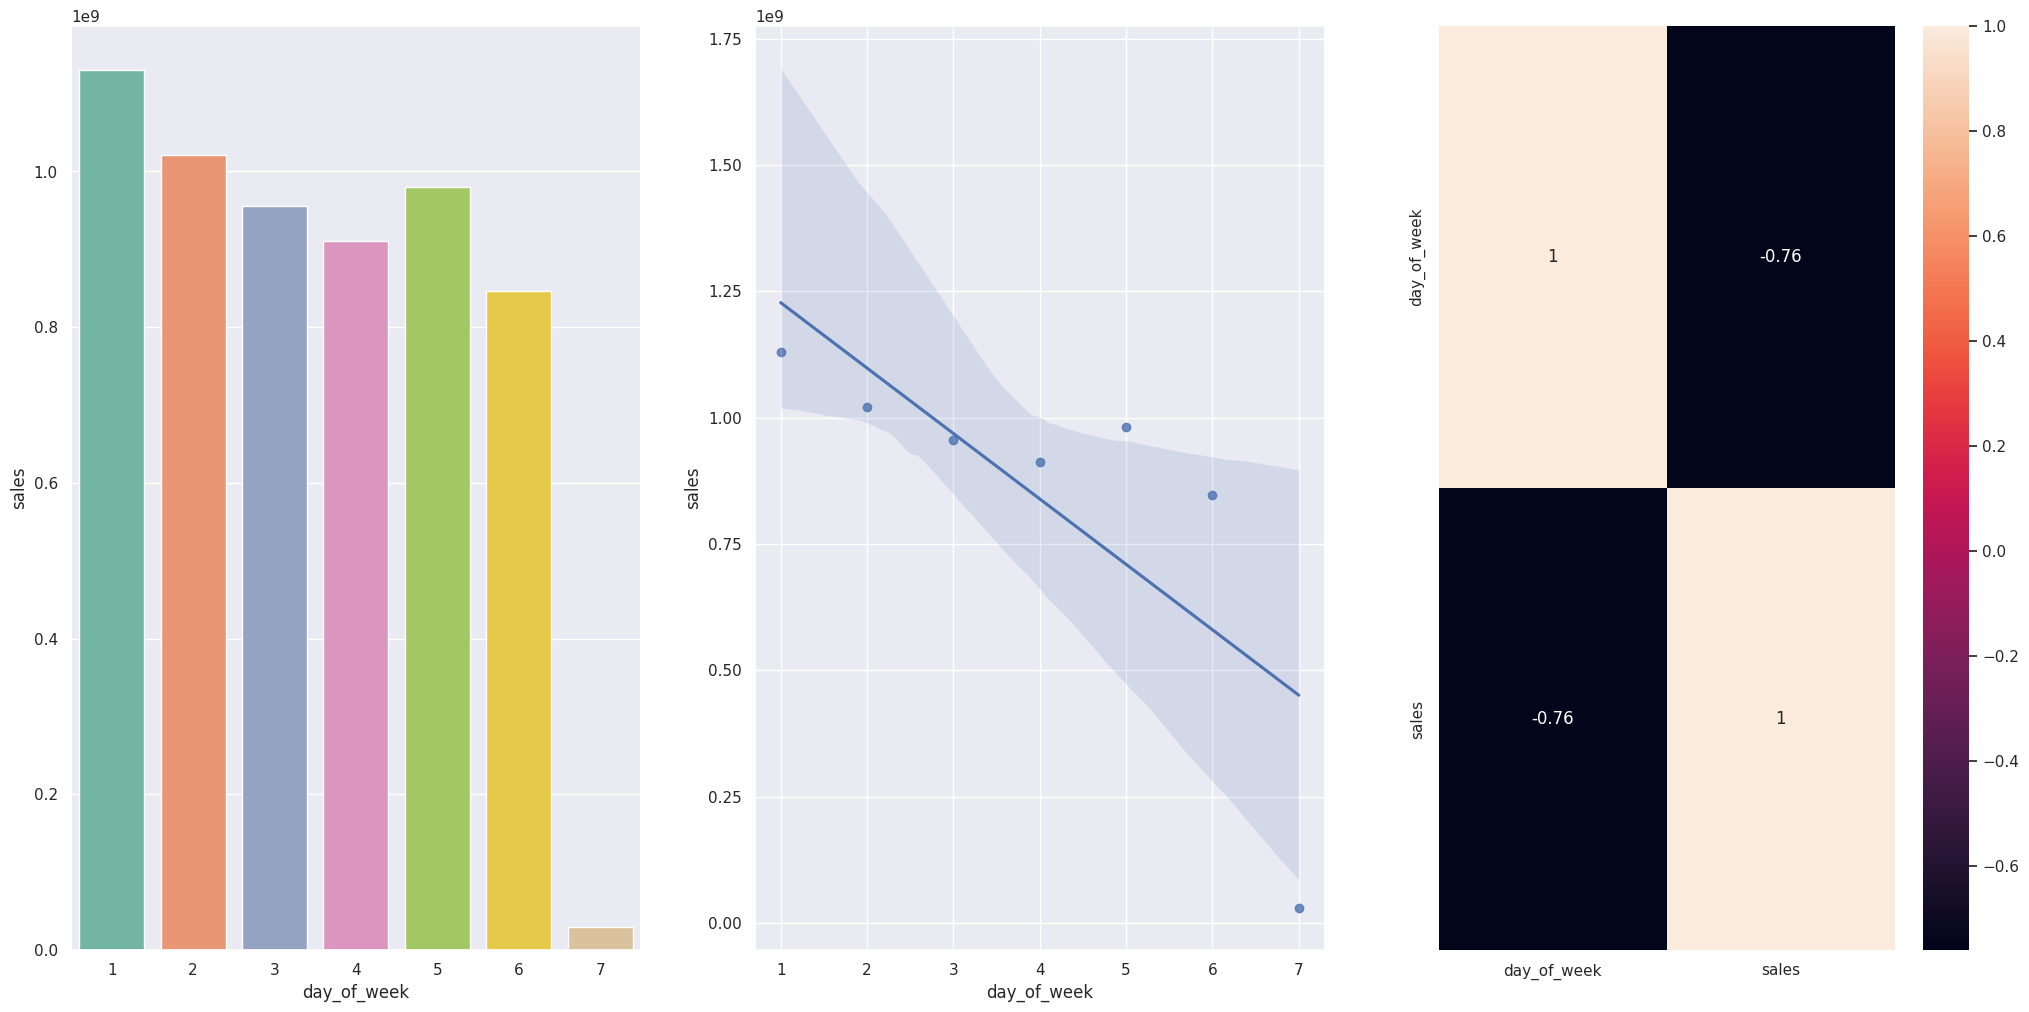

In [ ]:
aux1 = df4[['day_of_week', 'sales']].groupby('day_of_week').sum().reset_index()
plt.subplot(1,3,1)
sns.barplot(x= 'day_of_week', y= 'sales', data= aux1, palette=palette);
plt.subplot(1,3,2)
sns.regplot(x= 'day_of_week', y= 'sales', data= aux1);
plt.subplot(1,3,3)
sns.heatmap(aux1.corr(method='pearson'), annot = True)

### H13. Lojas deveriam vender menos durante os feriados escolares.
* Verdadeira. As lojas vendem menos nos feriados escolares, exceto julho e agosto.

<ipython-input-65-cff86626c39f>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x= 'school_holiday', y= 'sales', data= aux1, palette=palette);
<ipython-input-65-cff86626c39f>:3: UserWarning: The palette list has more values (8) than needed (2), which may not be intended.
  sns.barplot(x= 'school_holiday', y= 'sales', data= aux1, palette=palette);
<ipython-input-65-cff86626c39f>:6: UserWarning: The palette list has more values (8) than needed (2), which may not be intended.
  sns.barplot(x= 'month', y= 'sales',hue='school_holiday', data= aux2, palette=palette);


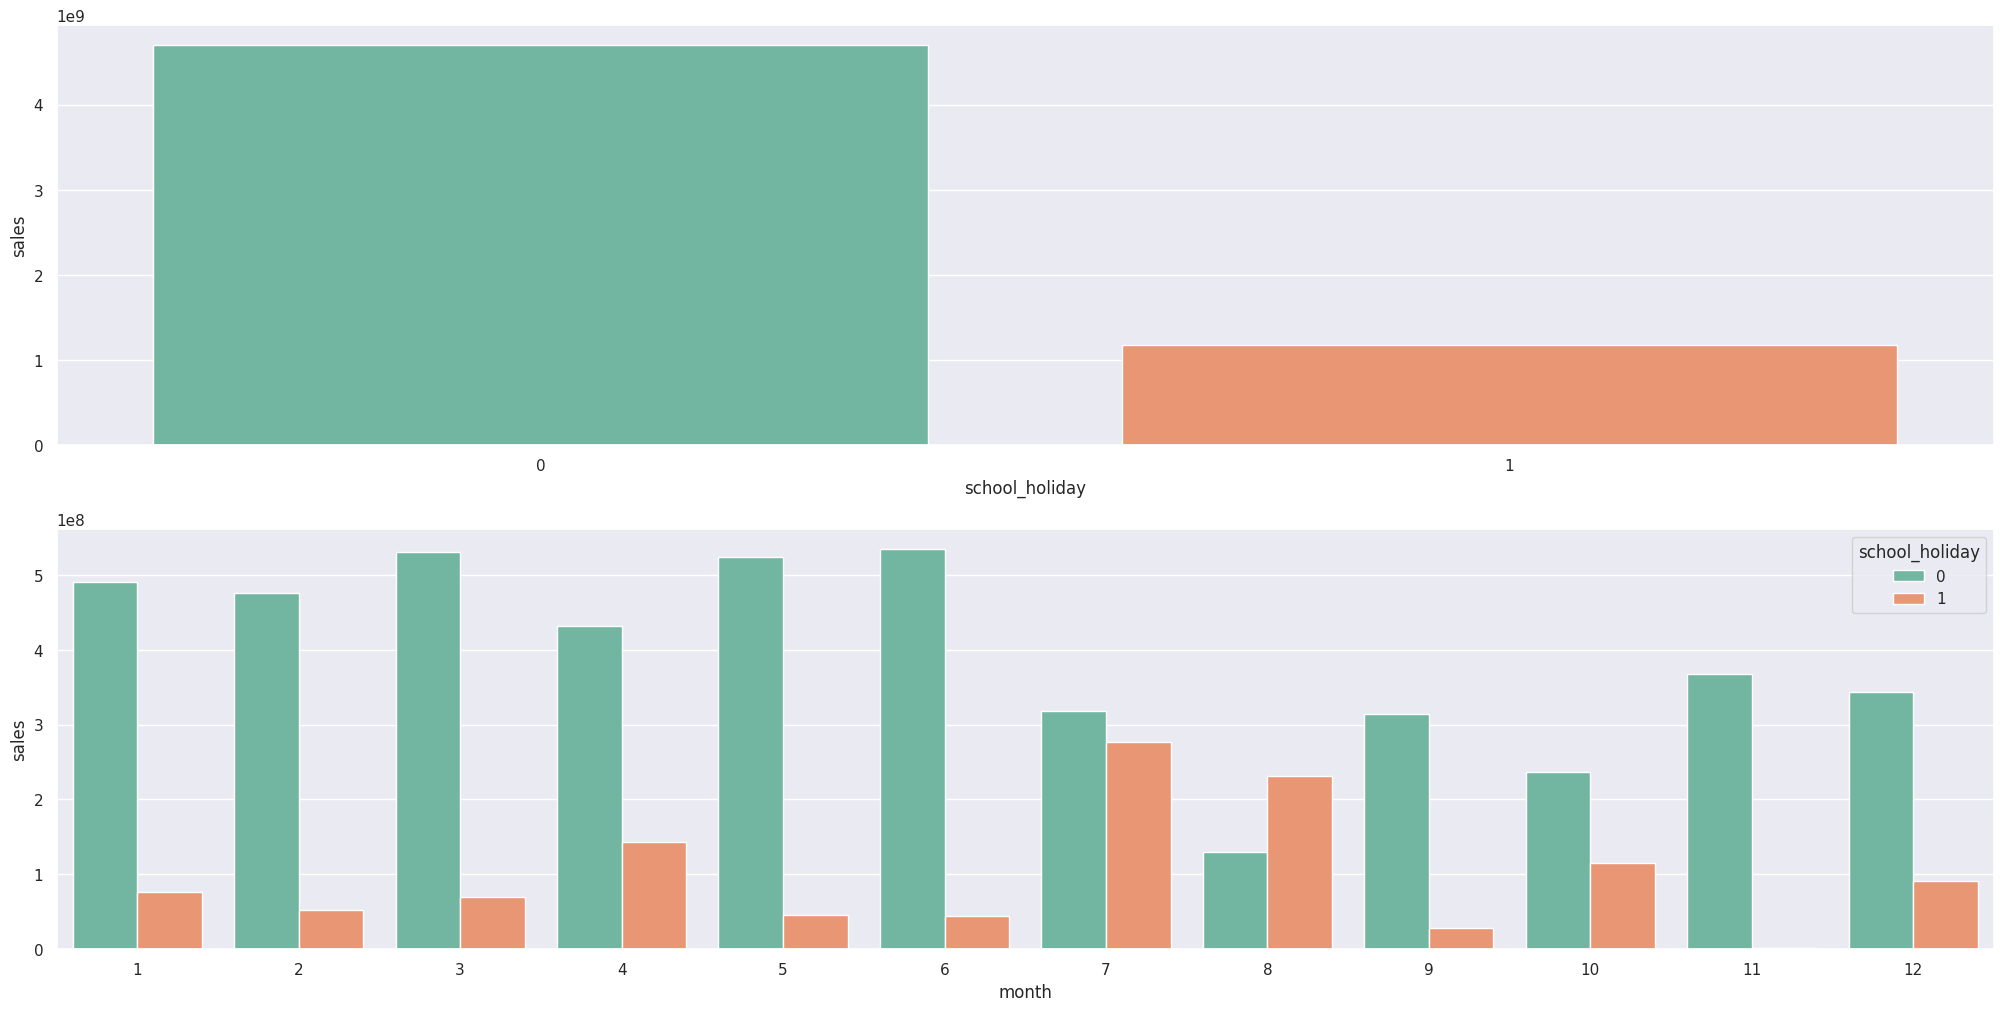

In [ ]:
plt.subplot(2,1,1)
aux1 = df4[['school_holiday', 'sales']].groupby('school_holiday').sum().reset_index()
sns.barplot(x= 'school_holiday', y= 'sales', data= aux1, palette=palette);
plt.subplot(2,1,2)
aux2 = df4[['month', 'school_holiday', 'sales']].groupby(['month', 'school_holiday']).sum().reset_index()
sns.barplot(x= 'month', y= 'sales',hue='school_holiday', data= aux2, palette=palette);

### 4.2.1 Resumo das hipóteses

In [ ]:
from tabulate import tabulate

In [ ]:
# comparação entre as features selecionadas pelo método Boruta no passo 6
# e a avaliação das features pelas hipóteses
#cols_selected_boruta

In [ ]:
tab = [['Hipóteses', 'Conclusão', 'Relevância'],
       ['H1', 'Falsa', 'Baixa'],
       ['H2', 'Falsa', 'Média'],
       ['H3', 'Falsa', 'Média'],
       ['H4', 'Falsa', 'Baixa'],
       ['H5', '-', '-'],
       ['H7', 'Falsa', 'Baixa'],
       ['H8', 'Falsa', 'Média'],
       ['H9', 'Falsa', 'Alta'],
       ['H10', 'Falsa', 'Alta'],
       ['H11', 'Verdadeira', 'Alta'],
       ['H12', 'Verdadeira', 'Alta'],
       ['H13', 'Verdadeira', 'Baixa']
       ]
print(tabulate(tab, headers= 'firstrow'))

Hipóteses    Conclusão    Relevância
-----------  -----------  ------------
H1           Falsa        Baixa
H2           Falsa        Média
H3           Falsa        Média
H4           Falsa        Baixa
H5           -            -
H7           Falsa        Baixa
H8           Falsa        Média
H9           Falsa        Alta
H10          Falsa        Alta
H11          Verdadeira   Alta
H12          Verdadeira   Alta
H13          Verdadeira   Baixa


## 4.3 Análise multivariada

In [ ]:
df4.dtypes

,0
store,int64
day_of_week,int64
date,datetime64[ns]
sales,int64
promo,int64
state_holiday,object
school_holiday,int64
store_type,object
assortment,object
competition_distance,float64


In [ ]:
num_attributes = df1.select_dtypes( include=['int64', 'float64'] )
cat_attributes = df1.select_dtypes( exclude=['int64', 'float64','datetime64[ns]'] )

### 4.3.1 Atributos numéricos

<Axes: >

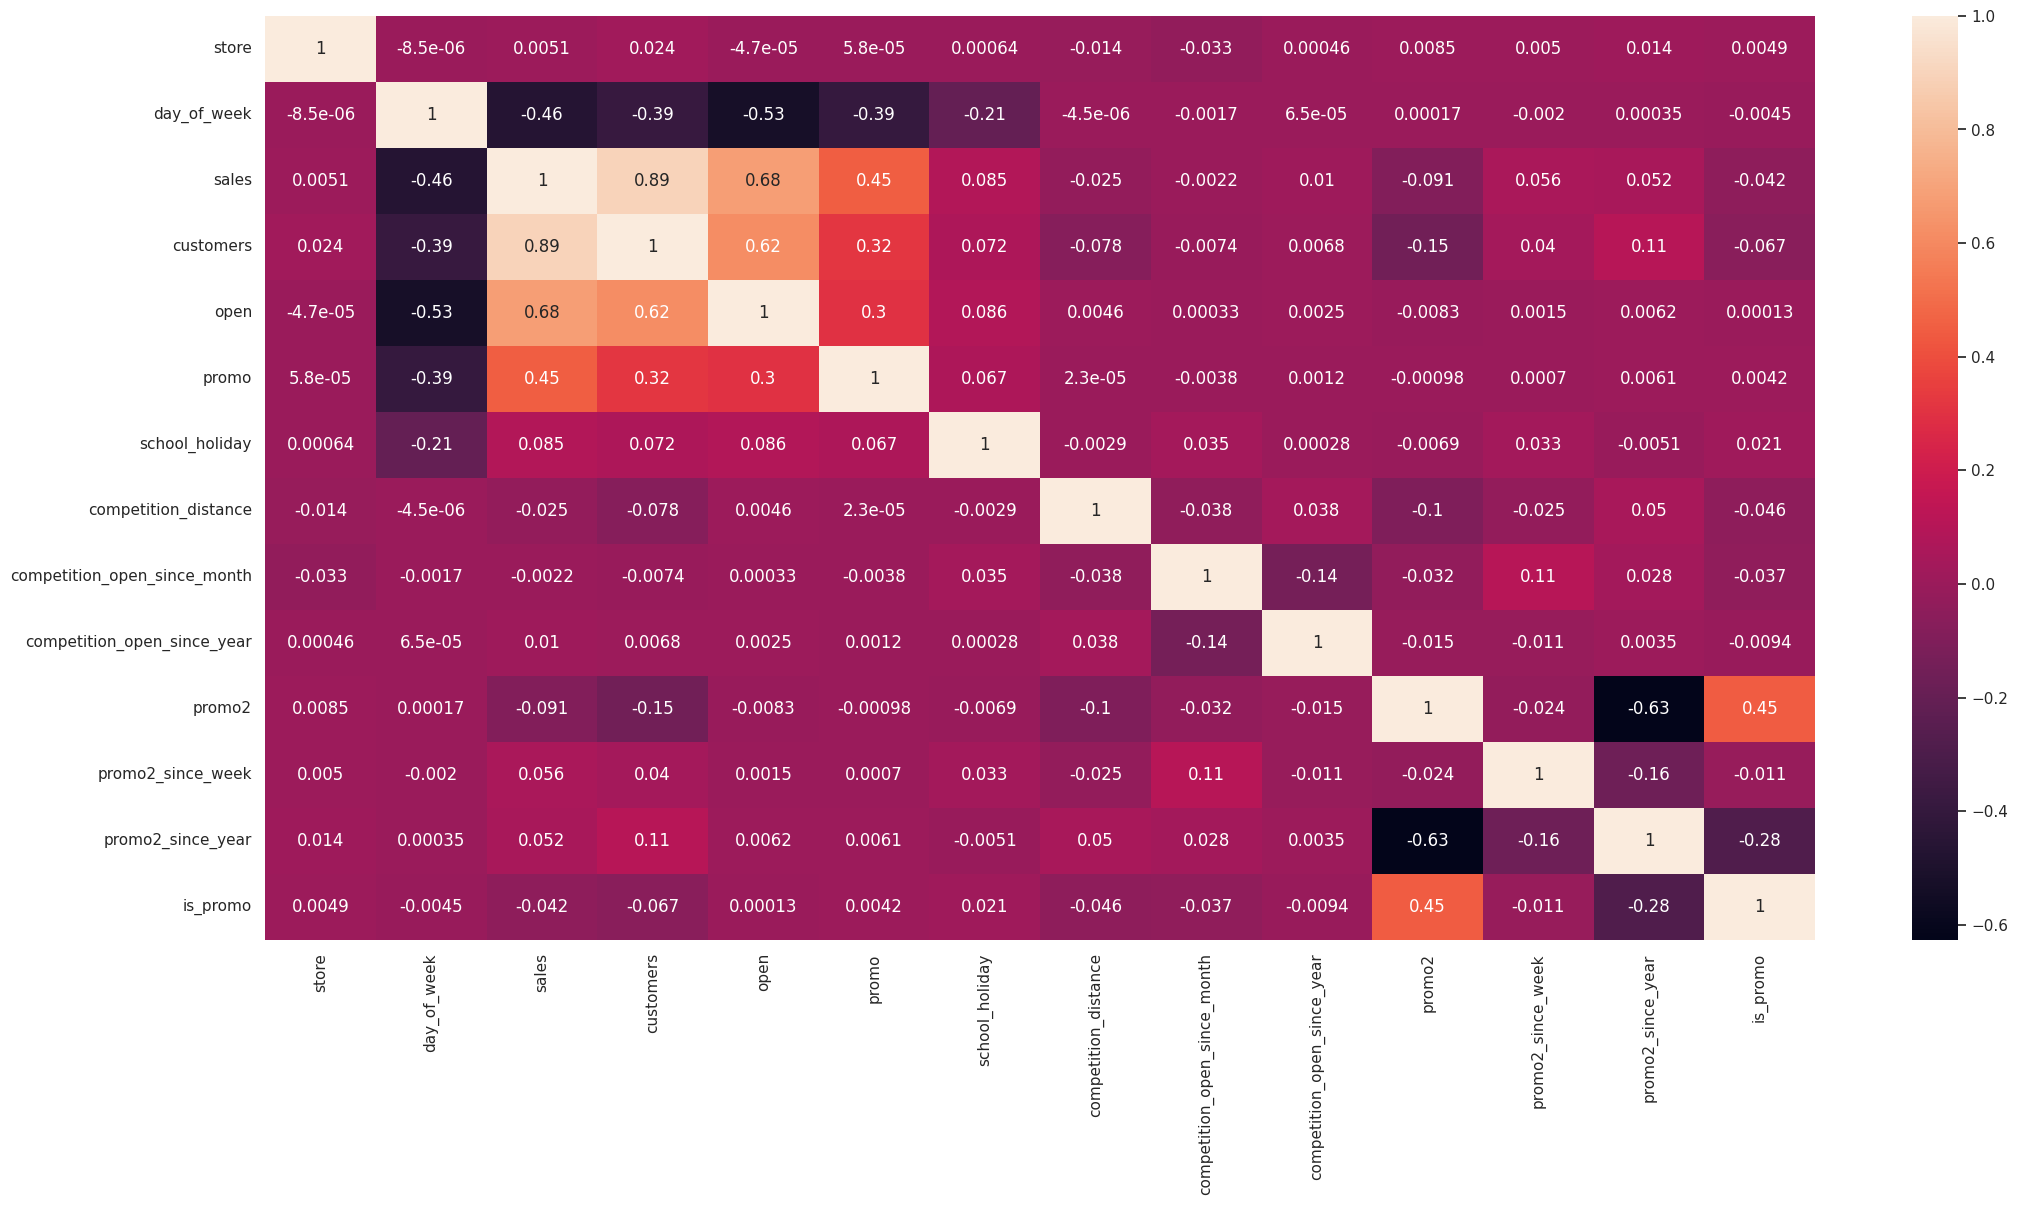

In [ ]:
correlation = num_attributes.corr(method='pearson')
sns.heatmap(correlation, annot = True)

### 4.3.2 Atibutos categóricos

In [ ]:
a = df4.select_dtypes(include=['object'])

In [ ]:
cramer_v(a['state_holiday'], a['store_type'])

0.07106469715258833

<Axes: >

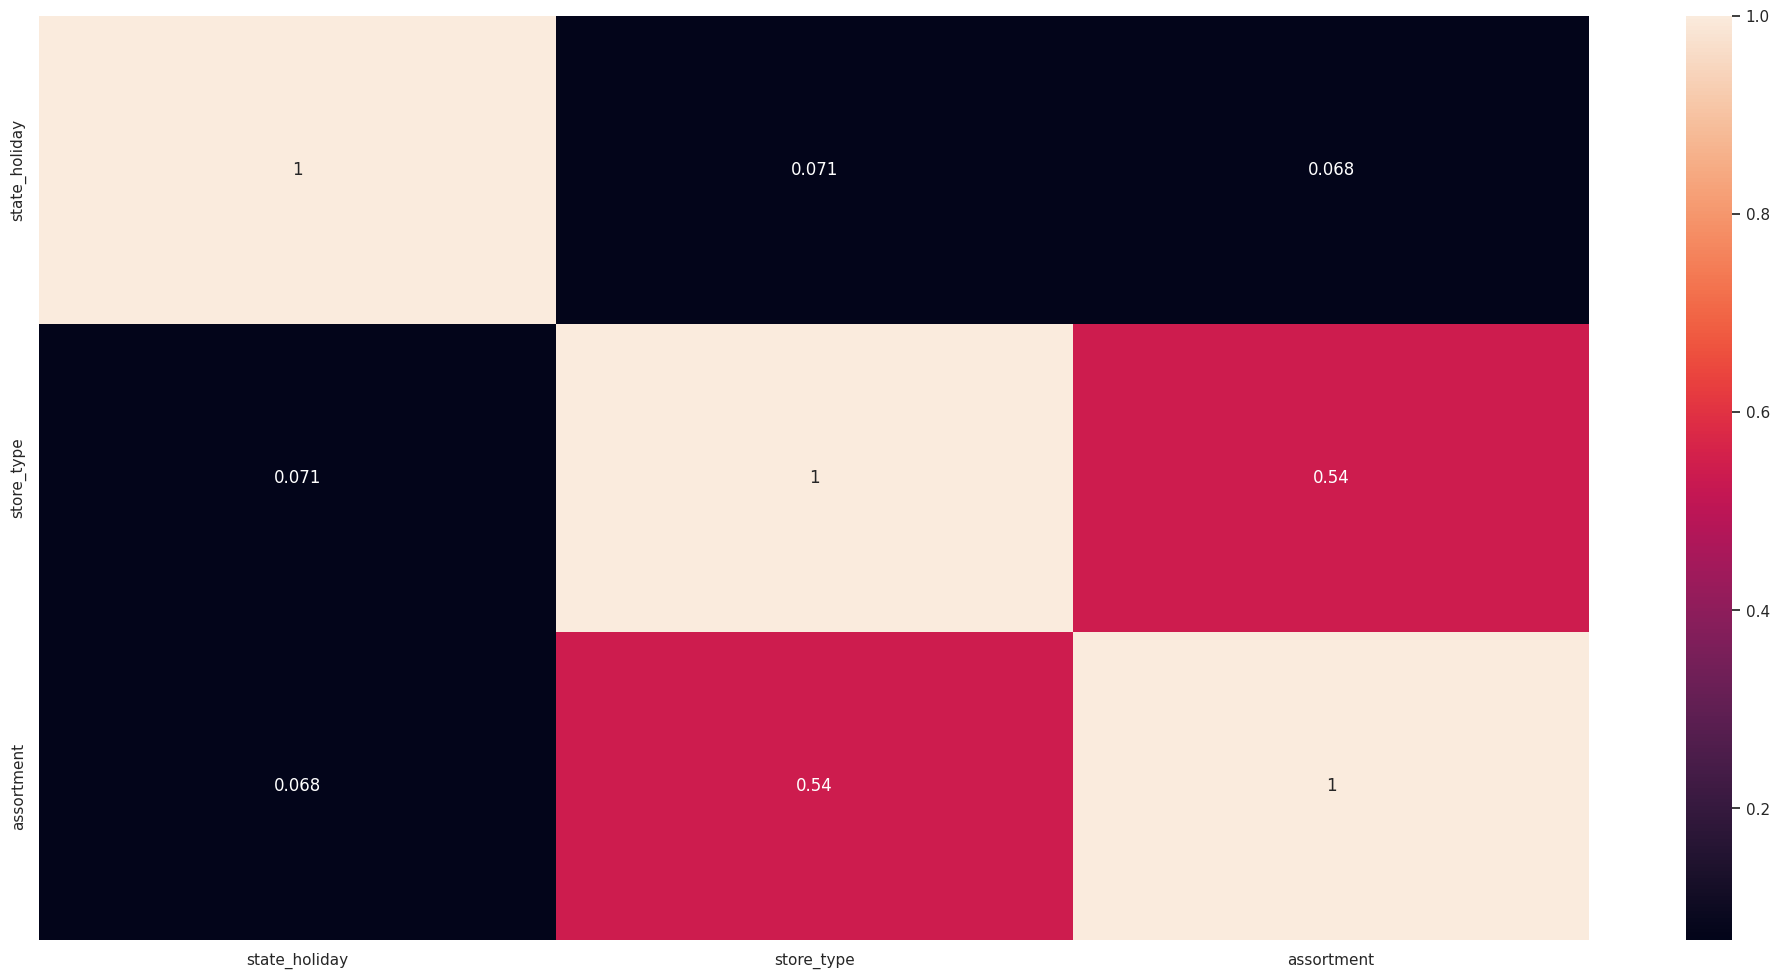

In [ ]:
# only categorical data
a = df4.select_dtypes(include=['object'])

# calculate Cramer's V

a1 = cramer_v(a['state_holiday'], a['state_holiday'])
a2 = cramer_v(a['state_holiday'], a['store_type'])
a3 = cramer_v(a['state_holiday'], a['assortment'])

a4 = cramer_v(a['store_type'], a['state_holiday'])
a5 = cramer_v(a['store_type'], a['store_type'])
a6 = cramer_v(a['store_type'], a['assortment'])

a7 = cramer_v(a['assortment'], a['state_holiday'])
a8 = cramer_v(a['assortment'], a['store_type'])
a9 = cramer_v(a['assortment'], a['assortment'])

# Final dataset
d = pd.DataFrame({'state_holiday': [a1, a2, a3],
              'store_type': [a4, a5, a6],
              'assortment': [a7, a8, a9]})

d = d.set_index(d.columns)

sns.heatmap(d, annot = True)

# 5.0 Passo 05 - Data Preparation

In [ ]:
df5 = df4.copy()

## 5.1 Normalizacao
* Não será usada pois não há features com comportamento de distibuição normal.

## 5.2 Rescaling

In [ ]:
a = df5.select_dtypes(include=['int64', 'float64', 'int32'])

In [ ]:
rs = RobustScaler()
mms = MinMaxScaler()
#competition distance
df5['competition_distance']=rs.fit_transform(df5[['competition_distance']].values)
#competition time month
df5['competition_time_month']=rs.fit_transform(df5[['competition_time_month']].values)
#promo time week
df5['promo_time_week']=mms.fit_transform(df5[['promo_time_week']].values)
#year
df5['year']=mms.fit_transform(df5[['year']].values)

## 5.3 Tranformacao

### 5.3.1 Encoding

In [ ]:
#state_holiday - One Hot Encoding
df5 = pd.get_dummies(df5, prefix= ['state_holiday'], columns = ['state_holiday'], dtype='int32' )
#store_type - Label Encoding
le = LabelEncoder()
df5['store_type'] = le.fit_transform(df5['store_type'])
#assortment - Ordinal Encoding
assortment_dict = {'basic': 1, 'extra': 2, 'extended': 3}
df5['assortment'] = df5['assortment'].map(assortment_dict)

### 5.3.2 Response variable transformation

In [ ]:
df5['sales'] = np.log1p(df5['sales'])

<Axes: xlabel='sales', ylabel='Count'>

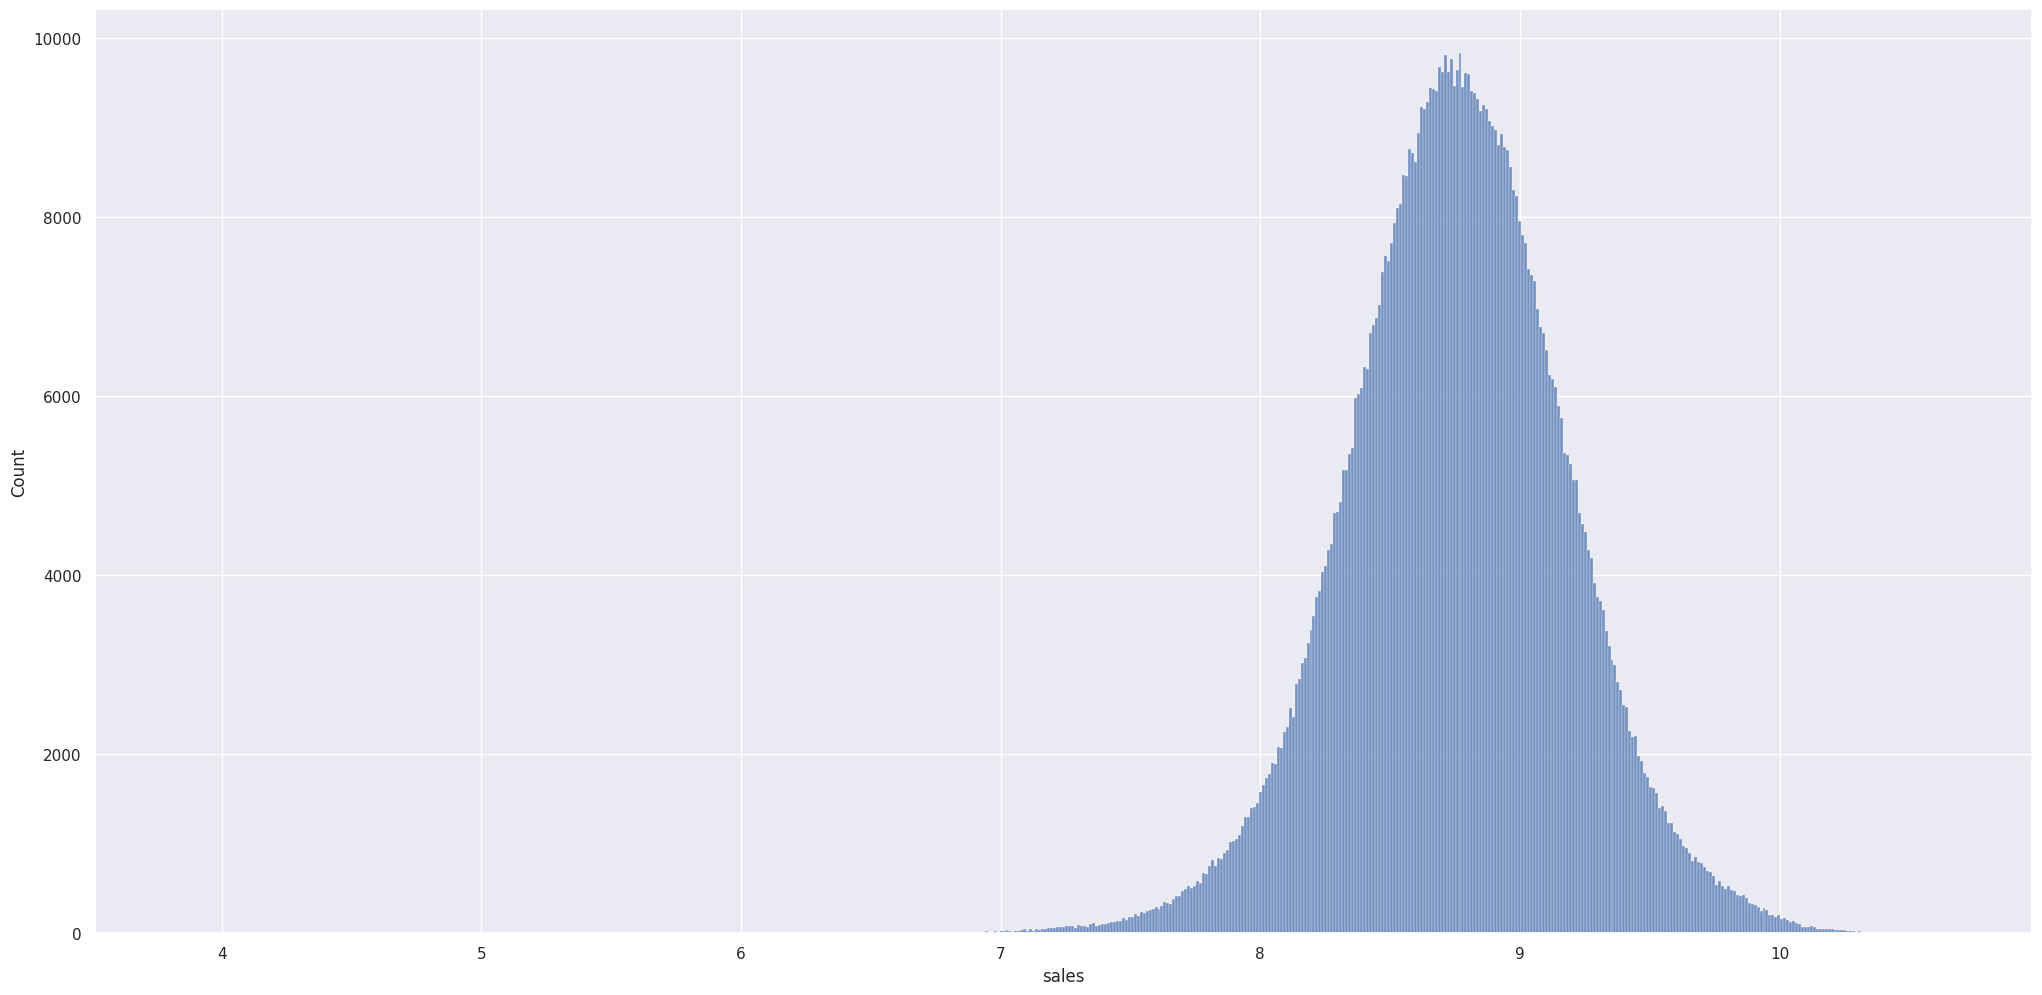

In [ ]:
sns.histplot(df5['sales'])

### 5.3.3 Nature transformation

In [ ]:
#day_of_week
df5['day_of_week_sin'] = df5['day_of_week'].apply(lambda x: np.sin(x * (2 * np.pi/7)))
df5['day_of_week_cos'] = df5['day_of_week'].apply(lambda x: np.cos(x * (2 * np.pi/7)))

#month
df5['month_sin'] = df5['month'].apply(lambda x: np.sin(x * (2 * np.pi/12)))
df5['month_cos'] = df5['month'].apply(lambda x: np.cos(x * (2 * np.pi/12)))
#day
df5['day_sin'] = df5['day'].apply(lambda x: np.sin(x * (2 * np.pi/30)))
df5['day_cos'] = df5['day'].apply(lambda x: np.cos(x * (2 * np.pi/30)))
#week_of_year
df5['week_of_year_sin'] = df5['week_of_year'].apply(lambda x: np.sin(x * (2 * np.pi/52)))
df5['week_of_year_cos'] = df5['week_of_year'].apply(lambda x: np.cos(x * (2 * np.pi/52)))

# 6.0 Passo 06 - Feature Selection

In [ ]:
df6 = df5.copy()

## 6.1 Split dataframe into training and test dataset


In [ ]:
# removendo features das quais outras colunas foram derivadas
cols_drop = ['week_of_year', 'day', 'month', 'day_of_week', 'promo_since', 'competition_since', 'year_week']
df6 = df6.drop(cols_drop, axis = 1)

In [ ]:
# dividindo o dataframe de modo que os dados de teste sejam os mais recentes
df6[['store', 'date']].groupby('store').max().reset_index()['date'][0] - datetime.timedelta(days = 6*7)

Timestamp('2015-06-19 00:00:00')

In [ ]:
#training dataset
X_train = df6[df6['date'] < '2015-06-19']
y_train = X_train['sales']
#test dataset
X_test = df6[df6['date'] >= '2015-06-19']
y_test = X_test['sales']

print(f'Training min date: {X_train["date"].min()}')
print(f'Training max date: {X_train["date"].max()}')
print(f'Test min date: {X_test["date"].min()}')
print(f'Test max date: {X_test["date"].max()}')

Training min date: 2013-01-01 00:00:00
Training max date: 2015-06-18 00:00:00
Test min date: 2015-06-19 00:00:00
Test max date: 2015-07-31 00:00:00


## 6.2 Boruta as Feature Selector

In [ ]:
#trainin and test dataset for boruta
X_train_n = X_train.drop(['date', 'sales'], axis = 1).values
y_train_n = y_train.values.ravel()
#define Random Forest Regressor
rf = RandomForestRegressor(n_jobs=-1)
#define boruta
boruta = BorutaPy(rf, n_estimators='auto', verbose=2, random_state=42).fit(X_train_n, y_train_n)

Iteration: 	1 / 100
Confirmed: 	0
Tentative: 	27
Rejected: 	0
Iteration: 	2 / 100
Confirmed: 	0
Tentative: 	27
Rejected: 	0
Iteration: 	3 / 100
Confirmed: 	0
Tentative: 	27
Rejected: 	0
Iteration: 	4 / 100
Confirmed: 	0
Tentative: 	27
Rejected: 	0
Iteration: 	5 / 100
Confirmed: 	0
Tentative: 	27
Rejected: 	0
Iteration: 	6 / 100
Confirmed: 	0
Tentative: 	27
Rejected: 	0
Iteration: 	7 / 100
Confirmed: 	0
Tentative: 	27
Rejected: 	0
Iteration: 	8 / 100
Confirmed: 	18
Tentative: 	0
Rejected: 	9


BorutaPy finished running.

Iteration: 	9 / 100
Confirmed: 	18
Tentative: 	0
Rejected: 	9


### 6.2.1 Best features from boruta

In [ ]:
cols_selected = boruta.support_.tolist()

#best features
X_train_fs = X_train.drop(['date', 'sales'], axis = 1)
cols_selected_boruta = X_train_fs.iloc[:, cols_selected].columns.to_list()
#not selected boruta
cols_not_selected_boruta = list(np.setdiff1d(X_train_fs.columns, cols_selected_boruta))

In [ ]:
cols_selected_boruta

['store',
 'promo',
 'store_type',
 'assortment',
 'competition_distance',
 'competition_open_since_month',
 'competition_open_since_year',
 'promo2',
 'promo2_since_week',
 'promo2_since_year',
 'competition_time_month',
 'promo_time_week',
 'day_of_week_sin',
 'day_of_week_cos',
 'month_cos',
 'day_sin',
 'day_cos',
 'week_of_year_cos']

In [ ]:
cols_not_selected_boruta

['is_promo',
 'month_sin',
 'school_holiday',
 'state_holiday_christmas',
 'state_holiday_easter_holiday',
 'state_holiday_public_holiday',
 'state_holiday_regular_day',
 'week_of_year_sin',
 'year']

In [ ]:
cols_not_selected_boruta=['is_promo',
 'month_sin',
 'school_holiday',
 'state_holiday_christmas',
 'state_holiday_easter_holiday',
 'state_holiday_public_holiday',
 'state_holiday_regular_day',
 'week_of_year_sin',
 'year']

## 6.3 Manual feature selection

In [ ]:
cols_selected_boruta = [
    'store',
    'promo',
    'store_type',
    'assortment',
    'competition_distance',
    'competition_open_since_month',
    'competition_open_since_year',
    'promo2',
    'promo2_since_week',
    'promo2_since_year',
    'competition_time_month',
    'promo_time_week',
    'day_of_week_sin',
    'day_of_week_cos',
    'month_sin',
    'month_cos',
    'day_sin',
    'day_cos',
    'week_of_year_sin',
    'week_of_year_cos']

#columns to add
feat_to_add = ['date', 'sales']
#final fatures
cols_selected_boruta_full = cols_selected_boruta.copy()
cols_selected_boruta_full.extend(feat_to_add)

In [ ]:
cols_selected_boruta

['store',
 'promo',
 'store_type',
 'assortment',
 'competition_distance',
 'competition_open_since_month',
 'competition_open_since_year',
 'promo2',
 'promo2_since_week',
 'promo2_since_year',
 'competition_time_month',
 'promo_time_week',
 'day_of_week_sin',
 'day_of_week_cos',
 'month_sin',
 'month_cos',
 'day_sin',
 'day_cos',
 'week_of_year_sin',
 'week_of_year_cos']

# 7.0 Passo 7 - Machine Learning Modelling

In [ ]:
x_train = X_train[cols_selected_boruta]
x_test = X_test[cols_selected_boruta]
#Time series data preparation
x_training = X_train[cols_selected_boruta_full]

## 7.1 Average Model

In [ ]:
aux1 = x_test.copy()
aux1['sales'] = y_test.copy()
#prediction
aux2 = aux1[['store', 'sales']].groupby('store').mean().reset_index().rename(columns = {'sales': 'predictions'})
aux1 = pd.merge(aux1, aux2, how = 'left', on = 'store')
yhat_baseline = aux1['predictions']
#performance
baseline_result = ml_error('Average model', np.expm1(y_test), np.expm1(yhat_baseline))
baseline_result

,Model Name,MAE,MAPE,RMSE
0,Average model,1354.800353,0.455051,1835.135542


## 7.2 Linear Regression Model

In [ ]:
#model
lr = LinearRegression().fit(x_train, y_train)
#prediction
yhat_lr = lr.predict(x_test)

#performance
lr_result = ml_error('Linear Regression', np.expm1(y_test), np.expm1(yhat_lr))
lr_result

,Model Name,MAE,MAPE,RMSE
0,Linear Regression,1867.949842,0.292928,2672.560928


### 7.2.1 Linear Regression Model - Cross Validation

In [ ]:
lr_result_cv =cross_validation(x_training, 5, 'Linear Regression', lr, verbose= False)
lr_result_cv

,Model Name,MAE CV,MAPE CV,RMSE CV
0,Linear Regression,2082.56+/-295.7,0.3+/-0.02,2953.41+/-467.93


## 7.3 Linear Regression Regularized Model - Lasso

In [ ]:
#model
lrr = Lasso(alpha=0.01).fit(x_train, y_train)
#prediction
yhat_lrr = lrr.predict(x_test)

#performance
lrr_result = ml_error('Linear Regression - Lasso', np.expm1(y_test), np.expm1(yhat_lrr))
lrr_result

,Model Name,MAE,MAPE,RMSE
0,Linear Regression - Lasso,1891.704881,0.289106,2744.451737


### 7.3.1 Lasso - Cross Validation

In [ ]:
lrr_result_cv =cross_validation(x_training, 5, 'Lasso', lrr, verbose= False)
lrr_result_cv

,Model Name,MAE CV,MAPE CV,RMSE CV
0,Lasso,2116.38+/-341.5,0.29+/-0.01,3057.75+/-504.26


## 7.4 Random forest Regressor

In [ ]:
#model
rf = RandomForestRegressor(n_estimators = 100, n_jobs = -1, random_state = 42).fit(x_train, y_train)
# prediction
yhat_rf = rf.predict(x_test)
# performace
rf_result = ml_error('Random Forest Regressor', np.expm1(y_test), np.expm1(yhat_rf))
rf_result

,Model Name,MAE,MAPE,RMSE
0,Random Forest Regressor,677.725992,0.099769,1008.766205


### 7.4.1 Random Forest Regressor - Cross Validation

In [ ]:
rf_result_cv =cross_validation(x_training, 5, 'Random Forest Regressor', rf, verbose= True)
rf_result_cv


K fold number: 5
                Model Name          MAE      MAPE         RMSE
0  Random Forest Regressor  1205.337902  0.149747  1788.227268

K fold number: 4
                Model Name         MAE      MAPE         RMSE
0  Random Forest Regressor  888.338862  0.136734  1344.110065

K fold number: 3
                Model Name         MAE      MAPE        RMSE
0  Random Forest Regressor  552.702933  0.088648  858.746718

K fold number: 2
                Model Name         MAE      MAPE         RMSE
0  Random Forest Regressor  856.025988  0.109307  1310.939783

K fold number: 1
                Model Name         MAE      MAPE         RMSE
0  Random Forest Regressor  697.130928  0.097275  1004.917946


,Model Name,MAE CV,MAPE CV,RMSE CV
0,Random Forest Regressor,839.91+/-218.64,0.12+/-0.02,1261.39+/-320.86


## 7.5 XGBoost Regressor

In [ ]:
#model
model_xgb = xgb.XGBRegressor(objective = 'reg:squarederror',
                             n_estimators = 100,
                             eta = 0.01,
                             max_depth = 10,
                             subsample = 0.7,
                             #colsample_bytree = 1.0,
                             #random_state = 42
                             ).fit(x_train, y_train)
# prediction
yhat_xgb = model_xgb.predict(x_test)
# performace
xgb_result = ml_error('XGBoost Regressor', np.expm1(y_test), np.expm1(yhat_xgb))
xgb_result

,Model Name,MAE,MAPE,RMSE
0,XGBoost Regressor,1695.95591,0.251864,2477.444589


### 7.5.1 XGBoost Regressor - Cross Validation

In [ ]:
xgb_result_cv =cross_validation(x_training, 5, 'XGBoost Regressor', model_xgb, verbose= True)
xgb_result_cv


K fold number: 5
          Model Name          MAE     MAPE         RMSE
0  XGBoost Regressor  2380.071543  0.27894  3420.449295

K fold number: 4
          Model Name          MAE      MAPE         RMSE
0  XGBoost Regressor  1630.536979  0.254474  2306.825507

K fold number: 3
          Model Name          MAE      MAPE        RMSE
0  XGBoost Regressor  1563.856819  0.248405  2238.33219

K fold number: 2
          Model Name          MAE      MAPE         RMSE
0  XGBoost Regressor  1936.201295  0.248443  2852.847565

K fold number: 1
          Model Name          MAE      MAPE         RMSE
0  XGBoost Regressor  1790.265602  0.240967  2604.896849


,Model Name,MAE CV,MAPE CV,RMSE CV
0,XGBoost Regressor,1860.19+/-290.34,0.25+/-0.01,2684.67+/-428.49


## 7.6 Compare Model's Performance

### 7.6.1 Single Performance

In [ ]:
modelling_result = pd.concat([baseline_result, lr_result, lrr_result, rf_result, xgb_result])
modelling_result.sort_values('RMSE')

,Model Name,MAE,MAPE,RMSE
0,Random Forest Regressor,677.725992,0.099769,1008.766205
0,Average model,1354.800353,0.455051,1835.135542
0,XGBoost Regressor,1695.955910,0.251864,2477.444589
0,Linear Regression,1867.949842,0.292928,2672.560928
0,Linear Regression - Lasso,1891.704881,0.289106,2744.451737


### 7.6.1 Real Performance - Cross Validation

In [ ]:
modelling_result_cv = pd.concat([ lr_result_cv, lrr_result_cv, rf_result_cv, xgb_result_cv])
modelling_result_cv.sort_values('RMSE CV')

,Model Name,MAE CV,MAPE CV,RMSE CV
0,Random Forest Regressor,839.91+/-218.64,0.12+/-0.02,1261.39+/-320.86
0,XGBoost Regressor,1860.19+/-290.34,0.25+/-0.01,2684.67+/-428.49
0,Linear Regression,2082.56+/-295.7,0.3+/-0.02,2953.41+/-467.93
0,Lasso,2116.38+/-341.5,0.29+/-0.01,3057.75+/-504.26


# 8.0 Passo 8 - Hyperparameter Fine Tuning

In [ ]:
import random

## 8.1 Random Search

In [ ]:
param = {
        'n_estimators' : [1500, 1700, 2000, 2500, 3500],
        'eta' : [0.01, 0.03],
        'max_depth' : [3, 5, 9],
        'subsample' : [0.1, 0.5, 0.7],
        'colsample_bytree' : [0.3, 0.7, 0.9],
        'min_child_weight' : [3, 8, 15]
}

max_eval = 10

In [ ]:
final_result = pd.DataFrame()
for i in range(max_eval):
    # choose values for parameters randomly
    hp = {k: random.sample(v, 1)[0] for k, v in param.items()}
    print(hp)
    #model
    model_xgb = xgb.XGBRegressor(objective = 'reg:squarederror',
                                n_estimators = hp['n_estimators'],
                                eta = hp['eta'],
                                max_depth = hp['max_depth'],
                                subsample = hp['subsample'],
                                colsample_bytree = hp['colsample_bytree'],
                                min_child_weight = hp['min_child_weight']
                                  )

    # performace
    result = cross_validation(x_training, 2, 'XGBoost Regressor', model_xgb, verbose = False)
    final_result = pd.concat([final_result, result])

final_result

{'n_estimators': 3500, 'eta': 0.01, 'max_depth': 9, 'subsample': 0.1, 'colsample_bytree': 0.3, 'min_child_weight': 8}
{'n_estimators': 1700, 'eta': 0.03, 'max_depth': 9, 'subsample': 0.7, 'colsample_bytree': 0.3, 'min_child_weight': 8}
{'n_estimators': 2500, 'eta': 0.01, 'max_depth': 9, 'subsample': 0.7, 'colsample_bytree': 0.7, 'min_child_weight': 15}
{'n_estimators': 1500, 'eta': 0.03, 'max_depth': 9, 'subsample': 0.1, 'colsample_bytree': 0.7, 'min_child_weight': 15}
{'n_estimators': 1500, 'eta': 0.01, 'max_depth': 9, 'subsample': 0.7, 'colsample_bytree': 0.7, 'min_child_weight': 3}
{'n_estimators': 1700, 'eta': 0.03, 'max_depth': 3, 'subsample': 0.7, 'colsample_bytree': 0.3, 'min_child_weight': 15}
{'n_estimators': 1500, 'eta': 0.03, 'max_depth': 3, 'subsample': 0.1, 'colsample_bytree': 0.7, 'min_child_weight': 8}
{'n_estimators': 1700, 'eta': 0.03, 'max_depth': 9, 'subsample': 0.1, 'colsample_bytree': 0.9, 'min_child_weight': 15}
{'n_estimators': 2000, 'eta': 0.03, 'max_depth': 9, 

,Model Name,MAE CV,MAPE CV,RMSE CV
0,XGBoost Regressor,923.09+/-87.49,0.12+/-0.01,1335.85+/-158.16
0,XGBoost Regressor,874.8+/-80.42,0.12+/-0.01,1269.24+/-153.3
0,XGBoost Regressor,855.98+/-83.77,0.11+/-0.01,1248.94+/-151.97
0,XGBoost Regressor,849.27+/-94.09,0.11+/-0.01,1227.96+/-160.08
0,XGBoost Regressor,941.85+/-74.97,0.13+/-0.01,1377.22+/-140.61
0,XGBoost Regressor,1603.03+/-51.05,0.22+/-0.0,2334.95+/-93.36
0,XGBoost Regressor,1543.35+/-52.7,0.21+/-0.0,2243.23+/-91.59
0,XGBoost Regressor,848.17+/-106.59,0.11+/-0.01,1225.05+/-182.19
0,XGBoost Regressor,829.22+/-82.23,0.11+/-0.01,1204.32+/-153.64
0,XGBoost Regressor,843.59+/-96.74,0.11+/-0.01,1223.6+/-164.31


## 8.2 Final Model

In [ ]:
#parametros aula
param_tuned = {
        'n_estimators' : 30,
        'eta' : 0.03,
        'max_depth' :9 ,
        'subsample' : 0.1,
        'colsample_bytree' : 0.7,
        'min_child_weight' : 15
}
#param_tuned = {'n_estimators': 15, 'eta': 0.03, 'max_depth': 9, 'subsample': 0.5, 'colsample_bytree': 0.9, 'min_child_weight': 8}
#max_eval = 2

In [ ]:
model_xgb_tuned = xgb.XGBRegressor(objective = 'reg:squarederror',
                                n_estimators = param_tuned['n_estimators'],
                                eta = param_tuned['eta'],
                                max_depth = param_tuned['max_depth'],
                                subsample = param_tuned['subsample'],
                                colsample_bytree = param_tuned['colsample_bytree'],
                                min_child_weight = param_tuned['min_child_weight']
                                  ).fit(x_train, y_train)
#predict
yhat_xgb_tuned = model_xgb_tuned.predict(x_test)
# performace
xgb_result_result = ml_error('XGBoost Regressor', np.expm1(y_test), np.expm1(yhat_xgb_tuned))
xgb_result_result

,Model Name,MAE,MAPE,RMSE
0,XGBoost Regressor,1783.745232,0.267871,2598.41843
